In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
from collections import deque
import warnings
from matplotlib.patches import Ellipse
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.neighbors import KNeighborsClassifier, KDTree

from tests import *
from gridspace import gen_gridded_space_DET, parse_map_for_GP, plot_truth_features, plot_sampled_features
from belief_model import BeliefModel, compare_models

# import truth map
from map_truth import plot_dict, feature_stats, show_grid
from map_truth import complex_feature_dict as feature_dict
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0. [Introduction](#Introduction)
    1. [Learning Objectives](#learning-objectives)
    2. [Notebook Overview](#overview)
    3. [Assumptions](#assumptions)

1. [Part 1 - Information Gain (5 points)](#part-1)
    1. [Part 1a - Entropy & Questions (5 points)](#part-1a)
    
2. [Part 2 - Belief Space Representation (20 points)](#belief)
    1. [Part 2a - Gaussian Processes (5 points)](#part-2a)
    2. [Part 2b - K-Neighbors (5 points)](#part-2b)
    3. [Part 2c - Compare/Contrast and Explore (10 points)](#part-2c)
    
3. [Part 3 - Adaptive Sampling (75 points)](#part-3)
    1. [Part 3a - Pure Exploration (5 points)](#part-3a)
    2. [Part 3b - Pure Exploitation (5 points)](#part-3b)
    3. [Part 3c - Explore-Exploit (10 points)](#part-3c)
    4. [Part 3d - Belief Model (5 points)](#part-3d)
    5. [Part 3e - Movement Cost (5 points)](#part-3e)
    6. [Part 3f - Select Best Point (10 points)](#part-3f)
    7. [Part 3g - Integration (10 points)](#part-3g)
    8. [Part 3h - Parameter Variation and Qualitative Questions (25 points)](#part-3h)

## Introduction <a id='Introduction' />

For this PSet you will walk through the core of adaptive sampling theory -- namely we'll be having you react to observations made in an unknown environment in order to best address a goal of your robot.  

**Please review the "Tutorial.pdf" document in the pset folder for a more detailed walk through of some of the core Adaptive Sampling concepts!**

### Learning Objectives <a id='learning-objectives' />

1. Understand the overall adaptive sampling algorithm 

2. Understand the impact of different ways to represent your belief map on the algorithm 

3. Understand the explore-exploit paradigm 

4. Understand how different action sets influence the adaptive sampling algorithm 


### Notebook Overview <a id='overview' />

This notebook will walk first walk through the idea of information gain and its mathematical representation.  Then two example mathematical models to represent the robot's belief state will be presented and you will compare and contrast the difference between them to understand some of the options and pros/cons in using different models for the belief map.  Then we will walk through building a myopic (short-sighted) adaptive sampling algorithm that allows flexibility between exploration and exploitation by using a scaling parameter.  Finally there will be several different cases where your algorithm will be tested with different trade off (beta) values for explore-exploit, different look horizons, different budgets, and the two different belief models and you will be asked to qualitatively summarize the differences between the parameters used in designing your algorithm.


## 1. Information Gain (5 pts) <a id='part-1' />



In adaptive sampling, your agent tries to maximize the utility which is a combination of exploitation and exploration rewards. You want to let the agent visit the most interesting points in the map, but you don't have enough knowledge about the world at first which requires the agent to explore the map. In order to do exploration efficiently, you want to provide the agent with **information gain** metric that the agent can explicitly maximize when it plans an action.

In this section, we will introduce you a brief overview of typical information metrics that are popular in an adaptive sampling community.

### 1a. Entropy as Information Gain  <a id='part-1a' />


### Shannon Entropy
Shannon Entropy is one of the extensively used metrics for adaptive sampling. 

Let us assume a point $X_i$ in a 2D map that represents the point's geographical location and corresponding features. For each point, we can associate a specific label or value $y_i$ that gives you a notion of how the point is valuable to you. Then, given $X_i$, the probability that $y_i = k$, where k is one particular label or value, is represented as $P\left(y_i=k \mid X_i\right)$. This is a conditional probability: *"given $X_i$, what's the label or value $y_i$ takes?"* Just for simplicity, we denote this $P\left(X_{i,k}\right)$ for the rest of the PSet and call it **belief model**.

Let us assume each $y_i$ takes one of $K$ labels. If we have a belief model $P\left(y_i=k \mid X_i\right)$ for each label $k \in K$, we can compute Shannon entropy of the given point $X_i$ as follows:

$$ H\left(X_i\right) = - \sum_{k=1}^K P\left(X_{i,k}\right)\log_2 P\left(X_{i,k}\right) $$

where

$$ \sum_{k=1}^K P\left(X_{i,k}\right) = 1 $$

This gives you *"uncertainty"* for each point. **The higher the entropy is, the more uncertain you are for that point.** After you compute the entropy value for every point in the given map, you can figure out where is the most uncertain.

### Rényi Entropy

Rényi entropy is a generalized form of Hartley entropy, Shannon entropy, collision entropy and min entropy. 


$$H_\alpha\left(X_i\right) = \frac{1}{1 - \alpha} \log \left(\sum_{k=1}^K P\left(X_{i,k}\right)^{\alpha}\right)$$

Shannon entropy is a special case of Rényi entropy when $\alpha \rightarrow 1$. If you are interested in the proof, you can look at this reference.  http://www.cnel.ufl.edu/courses/EEL6814/renyis_entropy.pdf

#### Qualitative Questions (5 points each):

Given the above formula, answer the following questions:

- What is the situation where you obtain maximum Shannon entropy? (There is a theoretical upper bound which is achieved for a certain $X_i$)


- How can we compute Shannon entropy for a continuous distribution? (when $y_i$ takes a continuous value rather than a discrete label). Please provide a mathematical formula.


---------------------------------------------------

*"""YOUR ANSWER HERE"""*

###*BEGIN SOLUTION*###

- What is the situation where you obtain maximum Shannon entropy? (There is a theoretical upper bound which is achieved for a certain  $X_i$)

#### Answer

When $P\left(X_{i}\right)$ is an uniform distribution.

====================================================================================================================

- How can we compute Shannon entropy for a continuous distribution? (when $y_i$ takes a continuous value rather than a discrete label). Please provide a mathematical formula.

#### Answer

$$ H\left(X_i\right) = - \int_{X_l}^{X_u} P\left(X_{i}\right)\log_2 P\left(X_{i}\right) dX_i $$

where

$$ \int_{X_l}^{X_u} P\left(X_{i}\right) dX_i = 1, \ \ \ X_i \in \left[X_l, X_u\right] $$

###*END SOLUTION*###

---------------------------------------------------

## 2. Belief Space Representation  (20 pts) <a id='belief' />

Let's discuss your world representation. In many adaptive sampling tasks, the robot has little to no information about the environment of interest. As samples are collected, the robot should be able to start modeling the environment probabilistically in order to inform the next trajectories.  For this example, we are assumign we are starting with a very low resolution set of samples (see grid below) and the robot needs to build a belief map from those initial sample so it can start exploring!

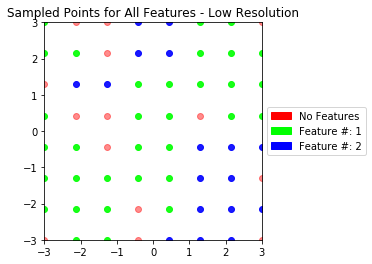

In [9]:
## DO NOT MODIFY ##
# LOW RESOLUTION MAP
N_initial_grid = 8
show_grid(N=N_initial_grid, feature_dict=feature_dict)

In [10]:
## DO NOT MODIFY ##
# We have also provided tools to parse this initial grid into training data format for the belief
X, Y, Z = gen_gridded_space_DET(feature_dict, N=N_initial_grid)
X_train, y_train = parse_map_for_GP(X, Y, Z)

### 2a. Gaussian Processes (5 pts) <a id='part-2a' />

As we learned in a previous lecture, GPs are a particualrly compelling technique for modeling distributions of a variable of interest when we are not interested or are not able to define specific parameters. We're asking you to keep a map of your belief through a GP representation for this exercise.

#### Kernel Variations 
The first Kernel used in Gaussian Processes we will discuss is the **Radial Basis Function (RBF) Kernel**.  This kernel is represented as:


$$k(x_i, x_j) = c \exp \left(-0.5 \left(\frac{||x_i - x_j||}{l}\right)^2\right)$$

where d is a distance function (uses Euclidean distance here), l is the length scale parameter, and c is a constant.  The "hyperparameters" of this kernel are the things that can be optimized to a given data set.  For this kernel above, c and l are the hyperparameters.

Note that there is an isotropic and anisotropic version of this kernel.  The isotropic kernel treats the length scale in each dimension of the space as the same, while the anisotropic kernel has a separate length scale parameter for each dimension of x.

Now you will see the the RBF kernels (isotropic and anisotopic) in action and be asked to comment on them.  In a classifier context (as we are using them), there is a separate kernel for each unique feature!

### Plot Interpretation Note:
Since we are using three different classes of feature (No feature, Feature 1, and Feature 2), we are able to show the belief map in one image with a different color challenge for each classification.  It is important to recognize that this is just a convienent representation device and there is a separate belief map for each class that are each overlayed together to form the total belief map.

Kernel values for each feature
1**2 * RBF(length_scale=1)
1**2 * RBF(length_scale=1)
1**2 * RBF(length_scale=1)


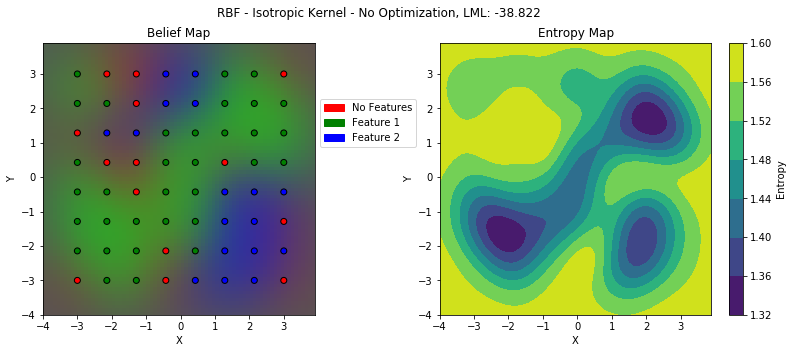

In [11]:
# ISOTROPIC KERNEL, UNOPTIMIZED (feel free to try different starting length scales in the kernel!)
kernel = 1.0 * RBF([1.0])

model = BeliefModel(kernel=kernel, optimize=False)
model.fit(X_train, y_train)
model.print_kernel()
titleStr = "RBF - Isotropic Kernel - No Optimization"
model.plot(plot_types=('belief', 'entropy'), title = titleStr)

Kernel values for each feature
1**2 * RBF(length_scale=[1, 1])
1**2 * RBF(length_scale=[1, 1])
1**2 * RBF(length_scale=[1, 1])


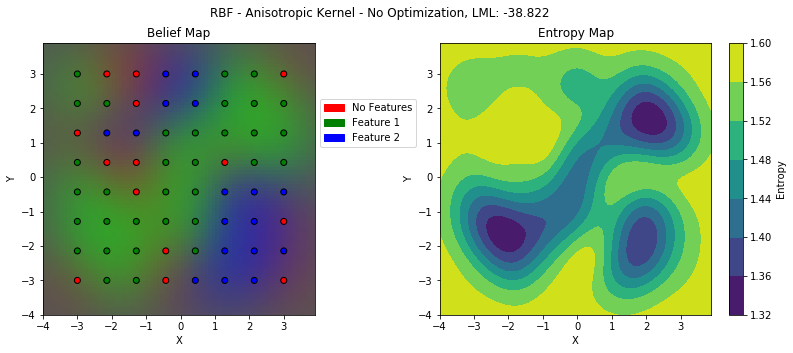

In [12]:
# ANISOTROPIC KERNEL, UNOPTIMIZED (feel free to try different starting length scales in the kernel!)
kernel = 1.0 * RBF([1.0, 1.0])

model = BeliefModel(kernel=kernel, optimize=False)
model.fit(X_train, y_train)
model.print_kernel()
titleStr = "RBF - Anisotropic Kernel - No Optimization"
model.plot(plot_types=('belief', 'entropy'), title=titleStr)

Kernel values for each feature
1.25**2 * RBF(length_scale=73.7)
2.4**2 * RBF(length_scale=0.997)
4.19**2 * RBF(length_scale=1.46)


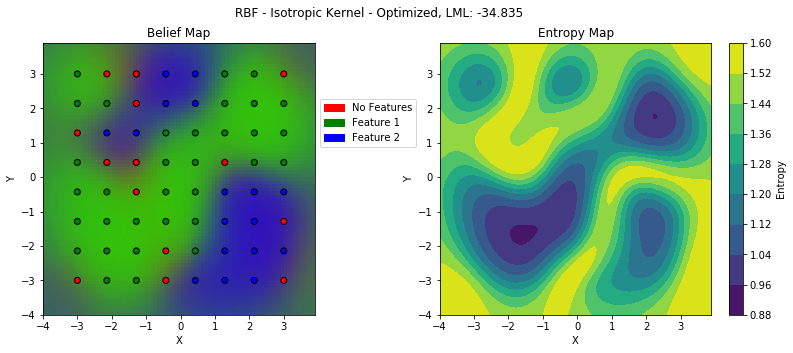

In [13]:
# ISOTROPIC KERNEL, OPTIMIZED
kernel = 1.0 * RBF([1.0])

model = BeliefModel(kernel=kernel, optimize=True)
model.fit(X_train, y_train)
model.print_kernel()     
titleStr = "RBF - Isotropic Kernel - Optimized"
model.plot(plot_types=('belief', 'entropy'), title=titleStr)

Kernel values for each feature
1.37**2 * RBF(length_scale=[1.65, 33])
4.01**2 * RBF(length_scale=[0.761, 1.27])
2.25**2 * RBF(length_scale=[1.06, 2.11])


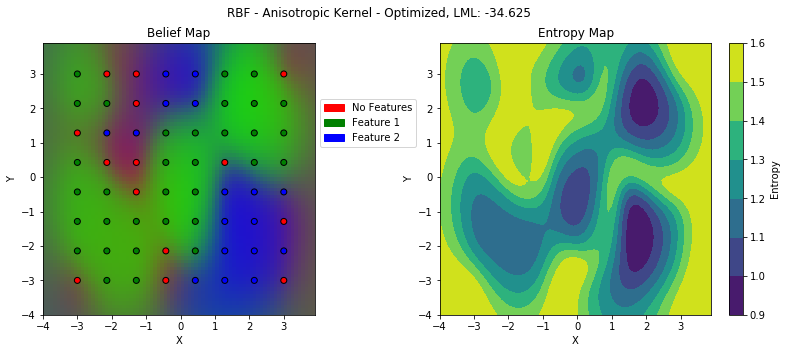

In [14]:
# ANISOTROPIC KERNEL, OPTIMIZED
kernel = 1.0 * RBF([1.0,1.0])

model = BeliefModel(kernel=kernel, optimize=True)

model.fit(X_train, y_train)
model.print_kernel()
        
titleStr = "RBF - Anisotropic Kernel - Optimized"
model.plot(plot_types=('belief', 'entropy'), title = titleStr)

#### Qualitative Question 1 (2.5 pts): 
Describe what is happening when the "kernel is optimized" (note we are using the default objective function for sklearn GaussianProcessClassifiers, so please explain that objective function and the decision variables) in the isotropic and anisotropic cases.  If you had a set of training points that had four dimensions (not counting the class value as a dimension), how many length scales could be used in the anisotropic case?

---------------------------------------------------

*"""YOUR ANSWER HERE"""*

###*BEGIN SOLUTION*###

When the "kernel is optimized", the objective function (in both cases) is the log-marginal-likelihood (*side note: optimizing for this causes features nearby each other to be more distinct, but the belief is usually more ambiguous further away from the training data*).  of the belief state given the training data.  The objective function is then:

$$ \max \log(prob(y|X)) $$

where the $prob(y|X)$ is a function of the kernel hyperparameters.  The kernel hyperparameters **are** the decision variables for this optimization.  In the isotropic case, this is only the constant value infront of the exponetial and the single length scale.  For the anisotropic case, there are N+1 hyperparameters, where N is the dimension of the training data since there is a length scale corresponding to each dimension of the training data.

If there was a training data set with four dimensions, then there would be up to four different possible length scales to use.  (and a total of 5 hyperparameters when the constant is included).

*Another side note: (not necessary to get points, but they may mention it): In the classification setting, there is a separate kernel for each feature class, so each kernel is trying to fit a belief map for that feature.  So the total number of variables for an anisotropic kernel classifier is really $F\cdot (N+1)$ where F is the number of features; however, each optimization is only performed on the N+1 hyperparameters, it is just repeated F times for the "separate" kernels.*


###*END SOLUTION*###

---------------------------------------------------

The next kernel we will investigate is the **Matern kernel**.  This kernel is isotropic only (in sklearn), but has an additional parameter ($\nu$ = nu) that is used to control the smoothness of the representation.  Some commonly used values are nu = 0.5, 1.5, and 2.5.  (see section 1.7.5.5. of [this link](http://scikit-learn.org/stable/modules/gaussian_process.html#matern-kernel) for the general case and specific cases of nu as mentioned above).  This nu value must be specified before hand and is not optimized for when fitting data.


Kernel values for each feature
1**2 * Matern(length_scale=1, nu=1.5)
1**2 * Matern(length_scale=1, nu=1.5)
1**2 * Matern(length_scale=1, nu=1.5)


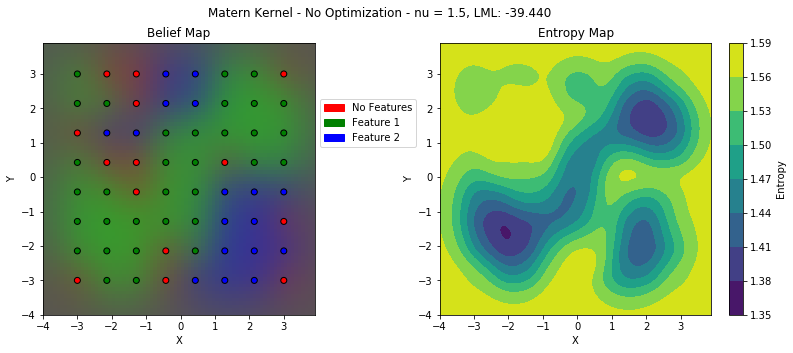

In [15]:
# MATERN KERNEL, UNOPTIMIZED (feel free to try different nu values)
nu = 1.5
kernel_M = 1.0 * Matern(nu=nu)

model = BeliefModel(kernel=kernel_M, optimize=False)
model.fit(X_train, y_train)
model.print_kernel()
        
titleStr = "Matern Kernel - No Optimization - nu = " + str(nu) 
model.plot(plot_types=('belief', 'entropy'), title=titleStr)

Kernel values for each feature
1.25**2 * Matern(length_scale=118, nu=1.5)
3.09**2 * Matern(length_scale=1.23, nu=1.5)
2.3**2 * Matern(length_scale=1.6, nu=1.5)


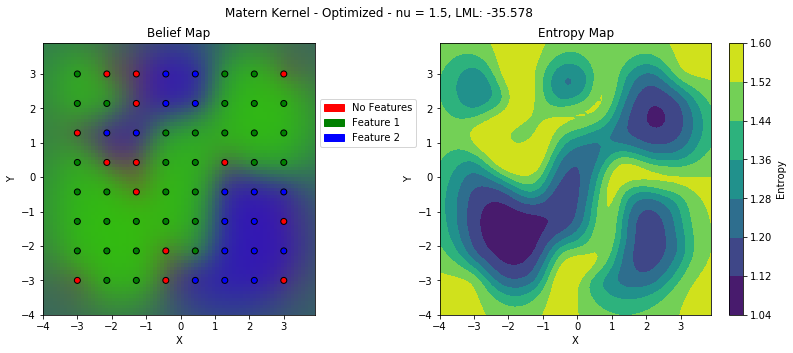

In [16]:
# MATERN KERNEL, OPTIMIZED (feel free to try different nu values)
nu = 1.5
kernel_M = 1.0 * Matern(nu = nu)

model = BeliefModel(kernel=kernel_M, optimize=True)
model.fit(X_train, y_train)
model.print_kernel()

titleStr = "Matern Kernel - Optimized - nu = " + str(nu) 
model.plot(plot_types=('belief', 'entropy'), title=titleStr)

#### Comparing Gaussian Process Kernels:
In the next cell we have provided plot comparison interface that  allows you to specify additional random points to sample and then re-optimize the kernel to see how it changes with more points.  Feel free to play around with different kernels to help answer the qualitative question below (each call with produce a new random point sample to add to the initial training data to refit the belief map).

Kernel Values Before New Random Points Added: 
Kernel values for each feature
1.25**2 * Matern(length_scale=118, nu=1.5)
3.09**2 * Matern(length_scale=1.23, nu=1.5)
2.3**2 * Matern(length_scale=1.6, nu=1.5)

Kernel values for each feature
1.37**2 * RBF(length_scale=[1.65, 33])
4.01**2 * RBF(length_scale=[0.761, 1.27])
2.25**2 * RBF(length_scale=[1.06, 2.11])


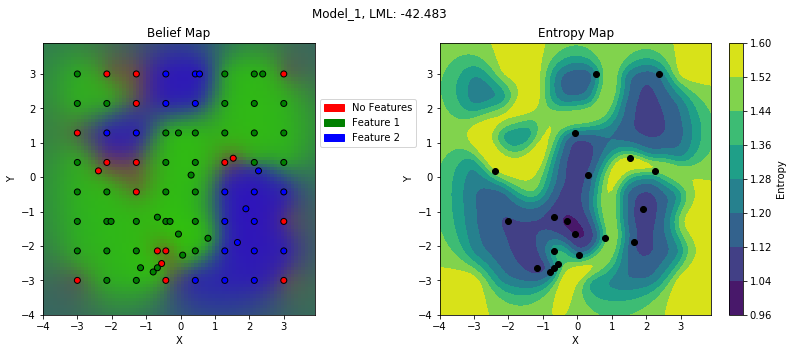

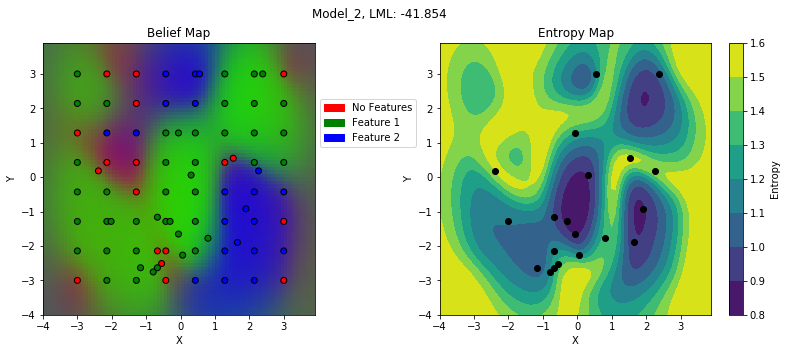

Kernel Values After New Random Points Added: 
Kernel values for each feature
1.27**2 * Matern(length_scale=218, nu=1.5)
4.16**2 * Matern(length_scale=1.07, nu=1.5)
7.94**2 * Matern(length_scale=1.78, nu=1.5)

Kernel values for each feature
1.11**2 * RBF(length_scale=[2.02, 65.2])
5.58**2 * RBF(length_scale=[0.792, 1.17])
2.94**2 * RBF(length_scale=[0.983, 2.07])


In [17]:
nu = 1.5  # Try different Nu values!
kernel_M = 1.0 * Matern(nu=nu)
model_1 = BeliefModel(kernel=kernel_M, optimize=True)
model_1.fit(X_train, y_train)
print("Kernel Values Before New Random Points Added: ")
model_1.print_kernel()

print()

        
kernel = 1.0 * RBF([1.0,1.0])
model_2 = BeliefModel(kernel=kernel, optimize=True)
model_2.fit(X_train, y_train)
model_2.print_kernel()
# set this to True, to include new points in the updated belief
newPointsFlag = True
# accepts 1 - 50
numberNewSamples = 20
compare_models(model_1, model_2, feature_dict, add_new_random_points=newPointsFlag , num_new_samples=numberNewSamples)

print("Kernel Values After New Random Points Added: ")
model_1.print_kernel()
print()
model_2.print_kernel()

#### Qualitative Question 2 (2.5 pts): 
Describe what happens as you more "training points" to a Gaussian Process kernel (in terms of the size of covariance matrix and the belief state accuracy).  Does it matter where the points are?


---------------------------------------------------

*"""YOUR ANSWER HERE"""*

###*BEGIN SOLUTION*###

As a new training points are added and the Gaussian Process is refit to the training data, the covariance matrix grows larger since there is another element in the training data that can be used as a truth point for the  kernel.  The belief state accuracy may increase if the point provides new information, but if too many points are added too close together then it may cause the optimization of the kernel hyperparameters to overfit to that one region and the belief map will lose accuracy in regions further away.  
###*END SOLUTION*###

---------------------------------------------------

### 2b. K-Neighbors (5 pts) <a id='part-2b' />

Another algorithm we could use to form our belief state is a k-nearest neighbors classifier.  This works just by a majority vote of the neighborest neighbors.  We have provided an interface that allows you to modify the number of nearest neighbors ("k") to consider in this kernel.  Note that this is not generally used in realistic systems for building a belief map because it is a non-generalized learning approach and suffers from overfitting.  However, hopefully it will illuminate that there are many options possible to use for a belief map and there may be instances in which an algorithm like this might be beneficial to your Adaptive Sampler.


K-Neighbors Classifier
n_neighbors = 5


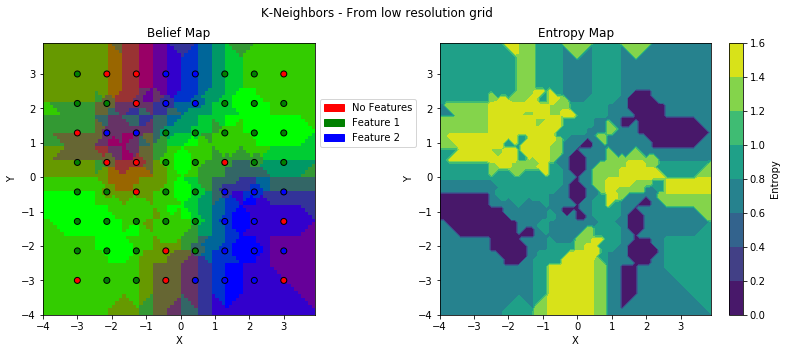

In [18]:
# Let's first look at K-neighbors with the low resolution grid 
# (feel free to try different n_neighbors values)
n_neighbors = 5
model = BeliefModel(gpFlag=False, n_neighbors=n_neighbors)
model.fit(X_train, y_train)
model.print_kernel()

titleStr = "K-Neighbors - From low resolution grid "
model.plot(plot_types=('belief', 'entropy'), title=titleStr)

# Notice that entropy is zero at some points that are surrounded by all similar neighbors!

K-Neighbors Classifier
n_neighbors = 5


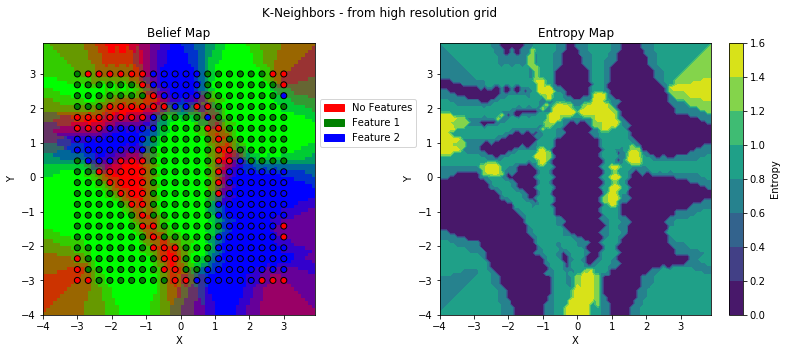

In [19]:
X, Y, Z = gen_gridded_space_DET(feature_dict, N=20)
X_train_highRes, y_train_highRes = parse_map_for_GP(X, Y, Z)

# What is run long enough to when exploring to get many points, what will that look like?
# (feel free to try different n_neighbors values)
n_neighbors = 5

model = BeliefModel(gpFlag=False, n_neighbors=n_neighbors)
model.fit(X_train_highRes, y_train_highRes)
model.print_kernel()
titleStr = "K-Neighbors - from high resolution grid"
model.plot(plot_types=('belief', 'entropy'), title=titleStr)

Kernel Values Before New Random Points Added: 
K-Neighbors Classifier
n_neighbors = 5

Kernel values for each feature
1.37**2 * RBF(length_scale=[1.65, 33])
4.01**2 * RBF(length_scale=[0.761, 1.27])
2.25**2 * RBF(length_scale=[1.06, 2.11])


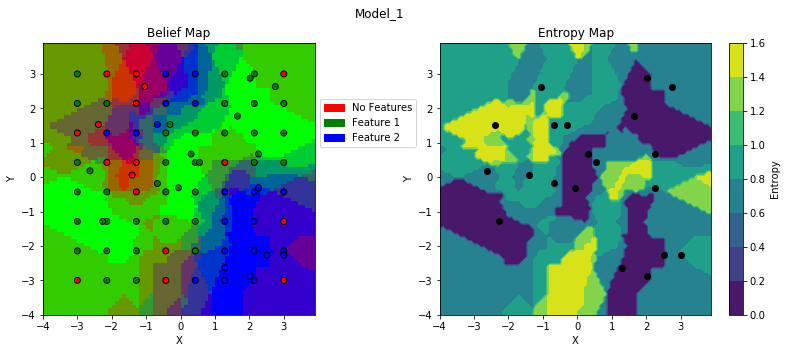

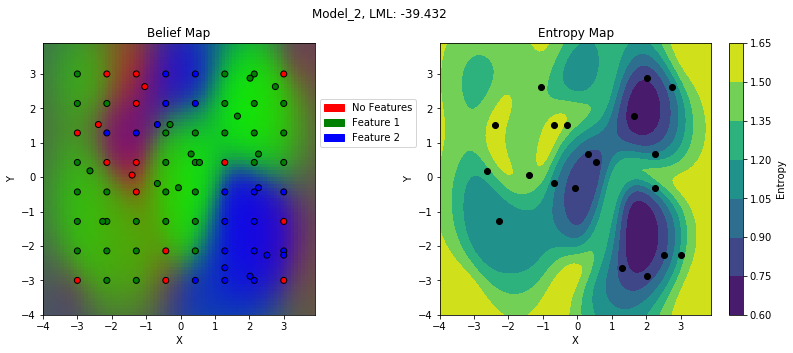

Kernel Values After New Random Points Added: 
K-Neighbors Classifier
n_neighbors = 5

Kernel values for each feature
1.79**2 * RBF(length_scale=[1.48, 25.4])
3.83**2 * RBF(length_scale=[0.91, 1.49])
3.47**2 * RBF(length_scale=[1.11, 1.78])


In [20]:
# Feel free to modify this cell to compare any two different belief models we are reviewed so far

# setup for a Kneighbors based model (feel free to modify n_neighbors)
n_neighbors = 5
model_1 = BeliefModel(gpFlag=False, n_neighbors=n_neighbors)
model_1.fit(X_train, y_train)

# feel free to modify the kernel here to test different GPs
kernel = 1.0 * RBF([1.0, 1.0])
model_2 = BeliefModel(kernel=kernel, optimize=True)
model_2.fit(X_train, y_train)

print("Kernel Values Before New Random Points Added: ")
model_1.print_kernel()
print()
model_2.print_kernel()

# set this to True, to include new points in the updated belief
newPointsFlag = True
# accepts 1 - 50
numberNewSamples = 20
compare_models(model_1, model_2, feature_dict, add_new_random_points=newPointsFlag, num_new_samples=numberNewSamples)

print("Kernel Values After New Random Points Added: ")
model_1.print_kernel()
print()
model_2.print_kernel()


#### Qualitative Question (5 pts):
What would the K-neighbors belief map look like as the number of points approached infinity? Is this appropriate in an adaptive sampling context?

---------------------------------------------------

*"""YOUR ANSWER HERE"""*

###*BEGIN SOLUTION*###

As the number of points (N) approached infinity, the map would asymptotically approach the truth map of the features, but there would also be some  regions of entropy near the edges between features; however, the size of this entropic region would approach zero as N approached infinity.  

However, this is not realistic in any scenario and especially in an adaptive sampling context, where the goal is to use the information in the current belief state to efficiently use the robot's resources and time.


###*END SOLUTION*###

---------------------------------------------------

### 2c. Compare/Contrast and Explore (10 pts) <a id='part-2c' />

1. Question 1 (5 points): Describe the main differences between what you observed in the K-neighbors and Gaussian Processes based feature classifiers.  When would you use one over the other, or might there be a way to incorporate the benefits of both into a single belief model?

2. Question 2 (5 points): Look at some of the multiclass and multilabel algorithms available on sklearn (list can be found [here](http://scikit-learn.org/stable/modules/multiclass.html) and a comparison on an example 2 feature dataset can be found [here](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py)).  If you could try out another classifier to use in an adaptive sampling scheme in the scenario here (2 different features that are not linearly separable), which would you pick and why?

---------------------------------------------------
Q1:
*"""YOUR ANSWER HERE"""*

###*BEGIN SOLUTION*###

(THIS IS A FAIRLY OPEN-ENDED QUESTION, SO AS LONG AS THEY GIVE A WELL REASONED RESPONSE, THEY SHOULD GET THE POINTS):

Example Response:  When using the K-neighbors classifier, it seemed to overfit to the training data and didn't have a smooth  nor seemingly accurate representation away from the training data, while the Gaussian Processes classifiers generalized well
across the belief space, but seemed to lose confidence if too many points clustered in one area.  I would definitely start off using a Gaussian Process based belief map for my initial movement planning and maybe try to incoporate a K-neighbors map locally if there are a lot of sample points in one area (which is then removed from the GP belief map).

###*END SOLUTION*###

---------------------------------------------------
---------------------------------------------------
Q2:
*"""YOUR ANSWER HERE"""*

###*BEGIN SOLUTION*###

(THIS IS A FAIRLY OPEN-ENDED QUESTION, SO AS LONG AS THEY GIVE A WELL REASONED RESPONSE, THEY SHOULD GET THE POINTS):

Example Response: For this scenario, it would be interesting to see how a Radial Basis Function Support Vector Machine (RBF SVM) would perform in comparison to the Gaussian Process RBF kernel.  Since they are both based off an exponential distance metric with a length scale, I think the results would be similar; however, the SVM is more conservative and doesn't have as high confidence away from data clusters, which may result in better overall performance if the sampler clusters several data points in one area.


###*END SOLUTION*###

---------------------------------------------------


In [21]:
from map_truth import simple_feature_dict as feature_dict
X, Y, Z = gen_gridded_space_DET(feature_dict, N=N_initial_grid)
X_init, y_init = parse_map_for_GP(X, Y, Z)

## 3. Adaptive Sampling (75 pts.) <a id='part-3' />

Now we will put it all together and run different scenarios on our test environment on a simpler environment (similar setup, but lower number of overlapping features)

### Assumptions for this toy problem: <a id='Assumptions' />

Adaptive sampling is usually part of a complex pipeline that has to deal with the real world, so to focus in on the core of adaptive sampling, we have made some simplifying assumptions for the problem presented in this Pset:
1. We will be using a classifier to represent our entire map.  For real robots, they have to worry about objects in the real world in addition to their "science" objectives.  For this problem, the map is entirely built from probabilistic feature classification algorithms that identify relevant science feature.
2. There is no uncertainty when a sample is taken.  In real world problems, taking a "sample" may also be probalistic (for example, it could be 90% grass and 10% coral), but in our problem, whenever a sample is taken, it is certain that it is either not a feature, or feature 1 or 2.
3.  Both the robots position and movement is deterministic and does not have any uncertainty.

Of course, from the other advanced lectures we know how to address all of these problems, but for this Pset we want you to focus on the core of adaptive sampling!


## Expressing Reward and Cost

Central to the adaptive sampling problem is expressing an objective (generally maximizing information gain or minimizing uncertainty) and formulating an appropriate reward and cost function for the vehicle. These functions are ultimately applied to all possible actions in order to choose the "best" action at that time.

For this PSet, we would like you to work with this objective:

$$ arg \max\limits_{r \in S} I(r) \quad \textrm{s.t.} \quad C(r) \leq B $$

That is, from all possible actions, choose the action which maximizes information along that action; subject to a budgetary constraint applied to the cost of the action.


### Base Sampler class

You will implement an intelligent agent that does adaptive sampling! Here, we provide you with a `BaseSampler` python class that you will extend to obtain a final adaptive sampling agent. Currently, most of the core methods are not yet implemented. In the questions below, you should inherit this class and implement each of the not-implemented-yet methods.

You will implement the following 7 methods:

- `sample_only_exploit`

- `sample_only_explore`

- `sample_explore_exploit`

- `update_belief`

- `movement_cost`

- `pick_next_point`

- `start_explore`


Also, this base class provides the following utility funcitons that you can exploit when you implement above methods.

- `_get_points_from_horizon`

- `_query_feature`

Each method has a detailed instruction for use, so please have a look at them.

In [22]:
class BaseSampler:
    """
    This is a Base class of your sampling agent.
    In this problem set, you will extend this class by inherit this class and
    implement each method which is currently not implemented yet.
    
    When you instantiate this class as well as all the inherited child classes, you should provide
    following inputs.
    
    Inputs:
        - world_map: numpy array, shape = (N, 2), 2D grid map of the given world
        - science_map: numpy array, shape = (N, ), corresponding feature of each point in the world_map
        - belief_model: the agent's belief model for the world_map
        - init_pose: numpy array, shape = (2, ), initial location of the agent
        - feature_stats: list of tuples (A, B), each element corresponds to each feature
            - A: float, mean of science reward for the feature
            - B: float, variance of science reward for the feature [NOT USED]
        - budget: dict, keys = {'distance', 'sampling'}
            - budget['distance']: float, the agent's distance budget
            - budget['sampling']: int, the agent's sampling budget
        - horizon (optional): float, the agent's reachable range
        - beta (optional): float, the agent's balancing factor for science reward and information gain
    
    """
    
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        self.world_map = world_map
        self.science_map = science_map
        self.model = belief_model
        self.pose = init_pose
        self.feature_stats = feature_stats

        # sampling hyper-parameters
        self.beta = beta
        self.horizon = horizon
        self.distance_budget = budget['distance']
        self.sampling_budget = budget['sampling']

        self.total_reward = 0
        self.points_traveled = deque([self.pose])
    
    def sample_only_exploit(self, points):
        raise NotImplementedError
    
    def sample_only_explore(self, points):
        raise NotImplementedError

    def sample_explore_exploit(self, points):
        raise NotImplementedError

    def update_belief(self, new_sample):
        raise NotImplementedError

    def movement_cost(self, point):
        raise NotImplementedError
        
    def pick_next_point(self):
        raise NotImplementedError

    def start_explore(self):
        raise NotImplementedError
    
    def _get_points_from_horizon(self, points):
        """
        This is a method to obtain M reachable points from the agent's current position.
        You need to provide `points` argument that has a collection of N 2D-points among which
        the method looks for all the reachable points.
        
        Inputs:
            - points: numpy array, shape = (N, 2)
        Outputs:
            - points_around: numpy array, shape = (M, 2)
        """
        
        look_horizon = min([self.distance_budget, self.horizon])
        points_around = points[np.all(points != self.pose, axis=1)]
        tree = KDTree(points_around)
        ind = tree.query_radius(self.pose.reshape([1, -1]), r=look_horizon)[0]
        return points_around[ind]

    def _query_feature(self, point):
        """
        This is a method to obtain feature of a given point.
        
        Inputs:
            - point: numpy array, shape = (2, )
        Outputs:
            - feature: scalar
        """
        
        feature = self.science_map[np.all(self.world_map == point, axis=1)]
        return feature
    

### 3a. Sampling Algorithm 1 - Focus only on exploitation (science reward) (5 pts) <a id='part-3a' />

**Exploitative -- High Values** -- Sometimes all we care about is collecting samples that are "interesting" because they have a high 'science' benefit. (One might think about the case of sampling in the ocean, and only focusing on areas with dissolved CO2 or methane higher than some baseline threshold). This is known as an exploitative reward. Write a function which takes in a series of sample measurements and selects the most exploitative sample.

In [23]:
class Sampler_1(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_1, self).__init__(world_map, science_map, belief_model, init_pose, 
                                        feature_stats, budget, horizon, beta)
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def sample_only_exploit(self, points):
        """
        This is a method to compute the best point that has the biggest expected science reward (expected value) among the query points.
        You can use Gaussian Process model in the sampler to calculate likelihoods of each feature for each point.
        
            e.g. likelihoods = self.model.predict_proba(point)
            (*Please be careful about the shape of input/output of the model.predict_proba() function!)
        
        As outputs, you need to return the best sampling location among the points and its corresponding expected science reward.
        
        Hint: you will need to use the self.feature_stats tuple (where the mean science value of each feature is stored)
        
        Inputs:
            - points: numpy array, shape = (N, 2)
        Outputs:
            - best_sample_loc: numpy array, shape = (2, )
            - best_mean: scalar, biggest expected science reward among the points
        
        """
        ### YOUR ANSWER HERE ###
        
        ### BEGIN SOLUTION
        
        likelihoods = self.model.predict_proba(points)
        
        
        means = np.sum(likelihoods * np.array(self.feature_stats)[:, 0], axis=1)

        best_idx = np.argmax(means)
        best_sample_loc = points[best_idx]
        best_mean = np.max(means)

        return best_sample_loc, best_mean
        
        ### END SOLUTION

Tests passed!!

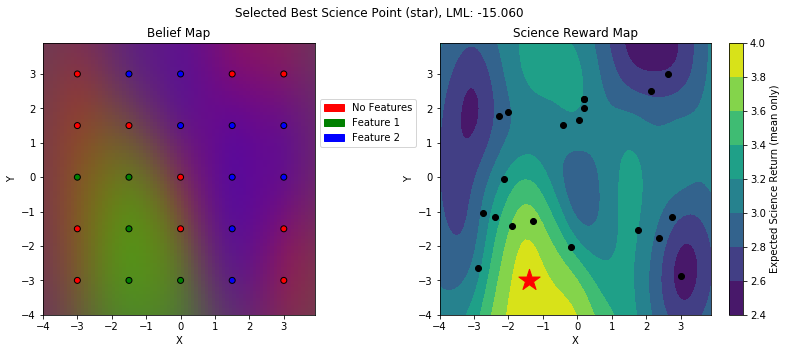

In [24]:
# Test your implementation here!
test_exploitation(Sampler_1)

### 3b. Sampling Algorithm 2 - Focus only on exploration (information gain) (5 pts) <a id='part-3b' />

**Explorative -- Coverage is Key** -- Now we consider the case in which we only care about collecting samples which we have low certainty on. For this metric we will use Shannon entropy, as defined in section 1.  **Be sure to address the case where the probability of a given feature is zero!  By definition in entropy assume:**
$$0 \cdot log(0) = 0$$

In [25]:
class Sampler_2(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_2, self).__init__(world_map, science_map, belief_model, init_pose, 
                                        feature_stats, budget, horizon, beta)
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def sample_only_explore(self, points):
        """
        This is a method to compute the best point that has the largest entropy among the query points.
        You can use Gaussian Process model in the sampler to calculate likelihoods of each feature for each point.
        
            e.g. likelihoods = self.model.predict_proba(point)
            (*Please be careful about the shape of input/output of the model.predict_proba() function!)
        
        As outputs, you need to return the best sampling location among the points and its corresponding entropy.
        
        Inputs:
            - points: numpy array, shape = (N, 2)
        Outputs:
            - best_sample_loc: numpy array, shape = (2, )
            - max_entropy: scalar, largest entropy among the points
        
        """
        ### YOUR ANSWER HERE ###
        
        ### BEGIN SOLUTION
        
        likelihoods = self.model.predict_proba(points)

        entropies = np.zeros(likelihoods.shape[0])
        for probs_ind in range(likelihoods.shape[0]):
            for el in likelihoods[probs_ind, :]:
                if np.isclose(el, 0.0):
                    # we should be adding 0 times positive infinity, which is 0 by convention of entropy
                    entropies[probs_ind] += 0
                else:
                    entropies[probs_ind] += -el * np.log2(el)
                        
        best_idx = np.argmax(entropies)
        best_sample_loc = points[best_idx]
        max_entropy = np.max(entropies)

        return best_sample_loc, max_entropy
        
        ### END SOLUTION

Tests passed!!

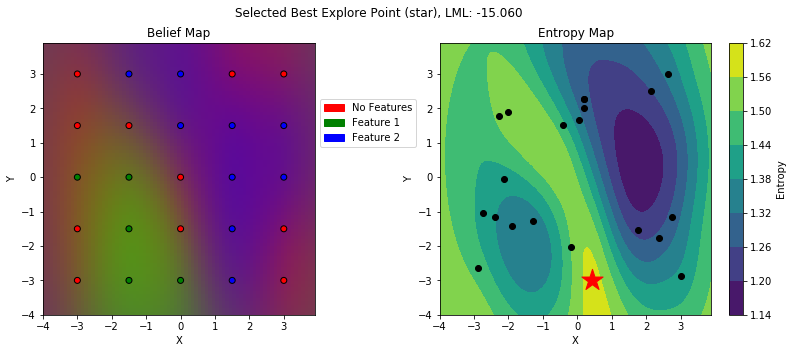

In [26]:
# Test your implementation here!
test_exploration(Sampler_2)

### 3c. Sampling Algorithm 3 - Balance science and information (10 pts) <a id='part-3c' />

**Trading off** -- Sometimes we actually care about both exploring in high value areas and seeing a lot of the world. This is the "explore-exploit" tradeoff, and this is well discussed in the literature. Often the elements of explore are weighted by some parameter  β . Please write a function that takes in a set of samples and some  β  and returns the best trade-off value.

For this implementation, frame it as a convex combination where β varies from 0 to 1 and modulates the focus on exploration vs. exploration.  Follow this equation:

$$x_{k+1} = argmax \left[(1 - \beta)\frac{exploit(x_k)}{max(exploit(X_k))} + \beta\frac{explore(x_k)}{max(explore(X_k)}\right]$$

where $x_k$ is a given point and $X_k$ is the set of points under consideration. $x_k \in X_k$

Remember that "exploit" and "exploration" may not be in the same units, so they should be normalized by the maximum value of each in the set (in this context).

In [27]:
class Sampler_3(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_3, self).__init__(world_map, science_map, belief_model, init_pose, 
                                        feature_stats, budget, horizon, beta)
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def sample_explore_exploit(self, points):
        """
        This is a method to compute the best point that trades off the biggest expected science reward and the largest entropy among the query points.
        You can use Gaussian Process model in the sampler to calculate likelihoods of each feature for each point.
        
            e.g. likelihoods = self.model.predict_proba(point)
            (*Please be careful about the shape of input/output of the model.predict_proba() function!)
        
        To allow trade-off, recall the member variable self.beta that balances the science reward and information gain.
        As outputs, you need to return the best sampling location among the points and its corresponding combined reward.
        
        Inputs:
            - points: numpy array, shape = (N, 2)
        Outputs:
            - best_sample_loc: numpy array, shape = (2, )
            - max_reward: scalar, maximum balanced reward of both science and information gain
        
        """
        
        ### YOUR ANSWER HERE ###
        
        ### BEGIN SOLUTION
        
        likelihoods = self.model.predict_proba(points)
        means = np.sum(likelihoods * np.array(self.feature_stats)[:, 0], axis=1)
        
        entropies = np.zeros(likelihoods.shape[0])
        for probs_ind in range(likelihoods.shape[0]):
            for el in likelihoods[probs_ind, :]:
                if np.isclose(el, 0.0):
                    # we should be adding 0 times positive infinity, which is 0 by convention of entropy
                    entropies[probs_ind] += 0
                else:
                    entropies[probs_ind] += -el * np.log2(el)

        rewards = (1 - self.beta) * means / means.max() + self.beta * entropies / entropies.max()

        best_idx = np.argmax(rewards)
        best_sample_loc = points[best_idx]
        max_reward = np.max(rewards)

        return best_sample_loc, max_reward
        
        ### END SOLUTION

Tests passed!!

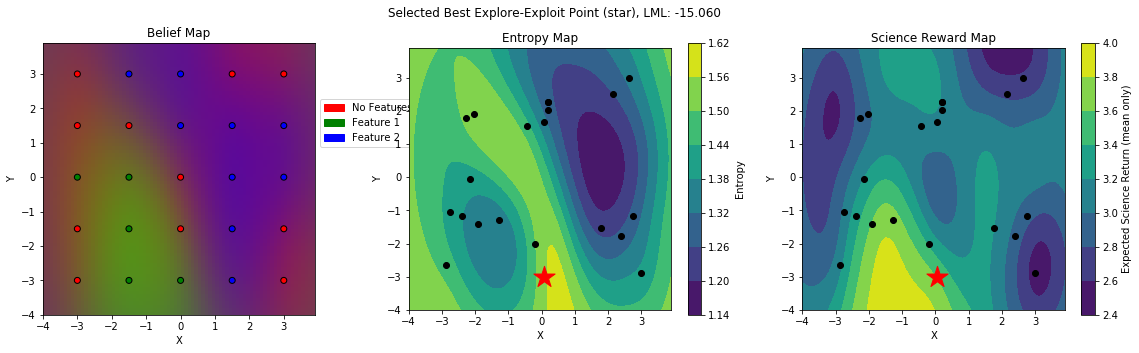

In [28]:
# Test your implementation here!
test_exploration_exploitation(Sampler_3)

### 3d. Update Belief Model (5 pts) <a id='part-3d' />

As we sample new points, we can also update our belief model to better incorporate new knowledge about the world. Here, in `Sampler_4` , please implement `update_belief` method that takes new sample point as input and updates the inner belief model. This function also should return a new train data set that has both previous data and new sample point data.

In [29]:
class Sampler_4(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_4, self).__init__(world_map, science_map, belief_model, init_pose, 
                                        feature_stats, budget, horizon, beta)
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def update_belief(self, new_sample):
        """
        This is a method to update the belief model of the sampler.
        You can call self.model.fit(X, y) again to update it.
        As outputs, you need to return the new training data X_new and y_new that have
        previous X_train and y_train, and X and y from the new_sample.
        
        Inputs:
            - new_sample: tuple (A, B)
                - A: numpy array, shape = (2, )
                - B: numpy array, shape = (1, )
        Outputs:
            - X_new: numpy array, shape = (N+1, 2)
            - y_new: numpy array, shape = (N+1, )
            
        Modifies:
            - self.model: a GaussianProcess instance, a belief model
        
        """
        
        ### YOUR ANSWER HERE ###
        
        ### BEGIN SOLUTION
        
        X_new = np.concatenate([self.model.X_train, new_sample[0].reshape(1, -1)], axis=0)
        y_new = np.concatenate([self.model.y_train, new_sample[1]], axis=0)

        self.model.fit(X_new, y_new)

        return X_new, y_new
    
        ### END SOLUTION

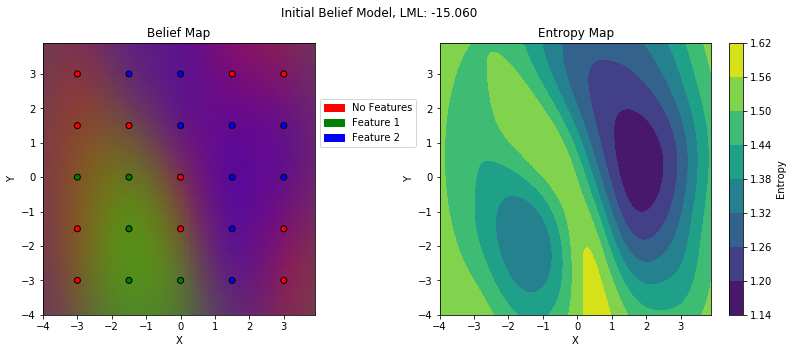

Tests passed!!

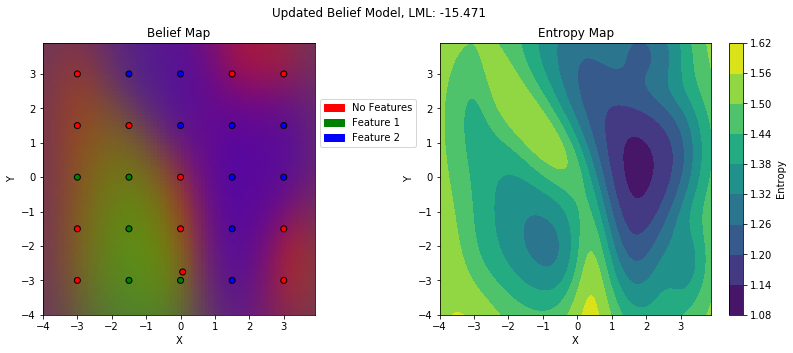

In [30]:
# Test your implementation here!
test_update_belief(Sampler_4)

### 3e. Compute Movement Cost (5 pts) <a id='part-3e' />

The agent has limited budgets for exploration. One of the common budgets is the maximum total distance for which the agent can explore the map. The agent should have a method to compute movement cost to properly update its remaining distance budget. In `Sampler_5` below, you are required to implement the `movement_cost` method for that purpose.

For this problem, we will just assume an **euclidean distance** movement cost.

**Qualitative Question (2.5 points):**
Please describe some other possible considerations for a real system budgets and provide some specific examples in the AUV context:

---------------------------------------------------

*"""YOUR ANSWER HERE"""*

###*BEGIN SOLUTION*###

( they don't need all of these, but at least 1-2 from each section)

Some other considerations include things like:
- power / energy use constraints
- data use constraints
- operations costs (crew time and monitoring fuel)
- Time
- Distance from another point

Specific AUV examples:
- Tether limitations for certain vehicles
- Maximum battery power limits control usage and maximum time
- Processing power onboard could limit the frequency of sampling
- Data storage could limit the total number of samples

###*END SOLUTION*###

---------------------------------------------------

In [31]:
class Sampler_5(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_5, self).__init__(world_map, science_map, belief_model, init_pose, 
                                        feature_stats, budget, horizon, beta)
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def movement_cost(self, point):
        """
        This is a method to compute cost of movement from the current position to a query point.
        Use euclidean distance for the cost.
        
        Inputs:
            - point: numpy array, shape = (2, )
        Outputs:
            - distance: scalar, euclidean distance between the sampler's pose and the query point.
        
        """
        
        ### BEGIN SOLUTION
        
        return np.linalg.norm(self.pose - point)
    
        ### END SOLUTION

In [32]:
# Test your implementation!
test_movement_cost(Sampler_5)

Tests passed!!

### 3f. Picking up Next Point for Sampling (10 pts) <a id='part-3f' />

Now we have everything we need to pick the next point we want to go. For this example, we are defining our "set of actions" as points within a given look horizon, so the set of actions available to your robot is defined by your robot position and the look horizon. Implement the `pick_next_point` method below in `Sampler_6` and be sure to not break your budget! 

In [33]:
class Sampler_6(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_6, self).__init__(world_map, science_map, belief_model, init_pose, 
                                        feature_stats, budget, horizon, beta)
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def pick_next_point(self):
        """
        This is a method to choose a next point to which the sampler is moving.
        Recall that the sampler has a limited range of movement - horizon. It also has distance budget as a constraint.
        You first need to compute all the reachable points from your location and then use the method `sample_explore_exploit`
        that you have implemented above to obtain the next point.
        
        Inputs:
            - NO INPUTS
        Outputs:
            - next_point: numpy array, shape = (2, ), next point to which the robot is moving
            - reward: scalar, balanced reward of the next_point
        
        """
        
        ### BEGIN SOLUTION
        
        available_points = self._get_points_from_horizon(self.world_map)
        next_point, reward = self.sample_explore_exploit(available_points)
        return next_point, reward
    
        ### END SOLUTION
        
    def sample_explore_exploit(self, points):
        "Copy and paste the `sample_explore_exploit` method that you have implemented in Sampler_3."
        
        ### YOUR ANSWER HERE ###
        
        ### BEGIN SOLUTION
        
        likelihoods = self.model.predict_proba(points)
        means = np.sum(likelihoods * np.array(self.feature_stats)[:, 0], axis=1)
        entropies = np.zeros(likelihoods.shape[0])
        for probs_ind in range(likelihoods.shape[0]):
            for el in likelihoods[probs_ind, :]:
                if np.isclose(el, 0.0):
                    # we should be adding 0 times positive infinity, which is 0 by convention of entropy
                    entropies[probs_ind] += 0
                else:
                    entropies[probs_ind] += -el * np.log2(el)

        rewards = (1 - self.beta) * means / means.max() + self.beta * entropies / entropies.max()

        best_idx = np.argmax(rewards)
        best_sample_loc = points[best_idx]
        max_reward = np.max(rewards)

        return best_sample_loc, max_reward
    
        ### END SOLUTION

In [34]:
# Test your implementation!
test_pick_next_point(Sampler_6)

Tests passed!!

### 3g Adaptive Sampler - Integrate everything together! (10 pts) <a id='part-3g' />

Now, you will put everything together to build an adaptive sampling algorithm!  Copy/paste your code below (so you don't have to scroll up and down) and implement the overall algorithm to spend all of your budget.

In [35]:
class AdaptiveSampler(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(AdaptiveSampler, self).__init__(world_map, science_map, belief_model, init_pose, 
                                              feature_stats, budget, horizon, beta)
        """
        Please do not change this initialization function. It might cause errors later.
        """
    
    def start_explore(self):
        """
        This is a main method of the sampler to explore the given world by using adaptive sampling!
        You ONLY need to implement a sampling/moving iteration loop because all the settings are
        initialied when you instantiate this class.
        You essentially have to do:
            - pick up next point and its corresponding reward
            - increment total reward
            - decrease distance budget
            - decrement sampling budget
            - update your current position
            - update your belief model
            - add a new location to the traveled list
            - stop when one of the budget elements reaches zero
        
        Inputs:
            - NO INPUTS
        Outputs:
            - NO OUTPUS
        Modifies:
            - self.model: a GaussianProcess instance, a belief model
            - self.pose: numpy array, shape = (2, ), the sampler's current position
            - self.total_reward: scalar, the sampler's internal accumulated reward
            - self.distance_budget: scalar, the sampler's internal distance budget
            - self.sampling_budget: scalar, the sampler's internal sampling budget
            - self.points_traveled: deque (list), the sampler's explored points (including the initial position)
        
        """
        
        ### YOUR ANSWER HERE ###
        
        ### BEGIN SOLUTION
        
        while self.distance_budget > 0 and self.sampling_budget > 0:
            # sample next point
            next_point, reward = self.pick_next_point()
            self.total_reward += reward
            self.distance_budget -= self.movement_cost(next_point)
            self.sampling_budget -= 1
            self.pose = next_point
            self.points_traveled.append(next_point)

            # update belief model
            feature = self._query_feature(next_point)
            next_sample = (next_point, feature)
            self.update_belief(next_sample)
    
        ### END SOLUTION
    
    def sample_explore_exploit(self, points):
        "Copy and paste the `sample_explore_exploit` method that you have implemented in Sampler_3."
        
        ### BEGIN SOLUTION
        
        likelihoods = self.model.predict_proba(points)
        means = np.sum(likelihoods * np.array(self.feature_stats)[:, 0], axis=1)
        entropies = np.zeros(likelihoods.shape[0])
        for probs_ind in range(likelihoods.shape[0]):
            for el in likelihoods[probs_ind, :]:
                if np.isclose(el, 0.0):
                    # we should be adding 0 times positive infinity, which is 0 by convention of entropy
                    entropies[probs_ind] += 0
                else:
                    entropies[probs_ind] += -el * np.log2(el)

        rewards = (1 - self.beta) * means / means.max() + self.beta * entropies / entropies.max()

        best_idx = np.argmax(rewards)
        best_sample_loc = points[best_idx]
        max_reward = np.max(rewards)

        return best_sample_loc, max_reward
    
        ### END SOLUTION
        
    def pick_next_point(self):
        "Copy and paste the `pick_next_point` method that you have implemented in Sampler_6."
        
        ### BEGIN SOLUTION
        
        available_points = self._get_points_from_horizon(self.world_map)
        next_point, reward = self.sample_explore_exploit(available_points)
        return next_point, reward
    
        ### END SOLUTION
        
    def update_belief(self, new_sample):
        "Copy and paste the `update_belief` method that you have implemented in Sampler_4."
        
        ### BEGIN SOLUTION
        
        X_new = np.concatenate([self.model.X_train, new_sample[0].reshape(1, -1)], axis=0)
        y_new = np.concatenate([self.model.y_train, new_sample[1]], axis=0)

        self.model.fit(X_new, y_new)

        return X_new, y_new
    
        ### END SOLUTION
        
    def movement_cost(self, point):
        "Copy and paste the `movement_cost` method that you have implemented in Sampler_5."
        
        ### BEGIN SOLUTION
        
        return np.linalg.norm(self.pose - point)
    
        ### END SOLUTION

In [36]:
# Test your implementation!
test_start_explore(AdaptiveSampler)

Tests passed!!

### 3h Parameter Variation and Questions (25 pts) <a id='part-3h' />
We have set up 12 different test cases below for you to see the affects from variations of beta, look horizon, and belief map.  Please run the following cells and answer questions throughout (there is a question after the 3rd, 6th, and 12th test case).  At the end of the 12th test case, we have left two cells for you to design your own mission to try any combination of beta, horizon, belief model, and budget (and answer one more question after those two cells).  Please be aware that the larger budget and look horizon, the longer the cell will take to run!

For the set 12 test cases, the budget will be fixed at a max distance of 50 units and a max number of samples of 30.

We provide you with a useful testing function `test_explorer` which takes as inputs ( *belief model, budget, horizon, and beta* ) to run the entire adaptive sampling process and visualize results.


In [37]:
# test explorer
def test_explorer(model, budget, horizon, beta):
    X, Y, Z = gen_gridded_space_DET(feature_dict, N=50)
    world_map, science_map = parse_map_for_GP(X, Y, Z)

    init_pose = np.array([0, 0])
    explorer = AdaptiveSampler(world_map, science_map, model, init_pose, feature_stats, budget, horizon, beta)
    explorer.start_explore()
    return explorer


# Belief Map: Isotropic Kernel GP
The first six examples will be with an isotropic Kernel GP, while the last six will be with three different belief maps (anisotropic RBF GP, Matern GP, and KNeighbors)
## Beta Variation: 0.25, 0.5, 0.75 

For the first three examples, we will vary beta while holding the look horizon at 2 units. 

In [38]:
budget = {'distance': 50, 'sampling': 30}
kernel = 1.0 * RBF([1.0])
horizon = 2
optimize = True

Initial Kernel
Kernel values for each feature
4.36**2 * RBF(length_scale=0.959)
23.6**2 * RBF(length_scale=2.32)
4.79**2 * RBF(length_scale=1.5)


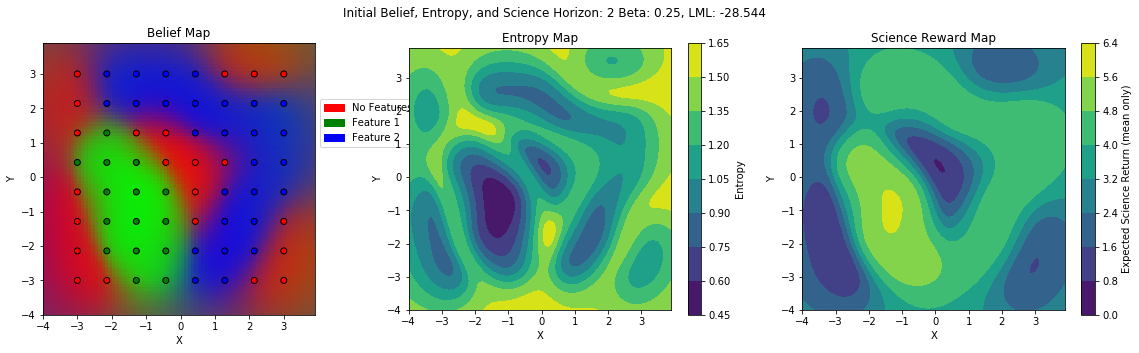

Final Kernel
Kernel values for each feature
4.35**2 * RBF(length_scale=0.978)
117**2 * RBF(length_scale=2.07)
12**2 * RBF(length_scale=1.68)


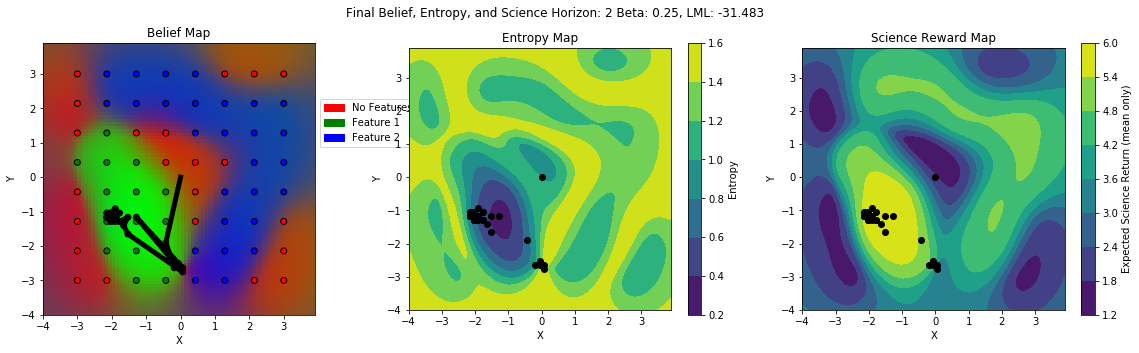

In [39]:
# BETA = 0.25
beta = 0.25

parameterStr = "Horizon: " + str(horizon) + " Beta: " + str(beta)
model = BeliefModel(kernel, optimize)
model.fit(X_init, y_init)
print("Initial Kernel")
model.print_kernel()
model.plot(title="Initial Belief, Entropy, and Science " + parameterStr, plot_types = ('belief','entropy', 'science'))
    
explorer = test_explorer(model,budget, horizon, beta)

print("Final Kernel")
explorer.model.print_kernel()

explorer.model.plot(title="Final Belief, Entropy, and Science "+ parameterStr,plot_types = ('belief','entropy', 'science'),lines=np.array(explorer.points_traveled),points=np.array(explorer.points_traveled))


Initial Kernel
Kernel values for each feature
4.36**2 * RBF(length_scale=0.959)
23.6**2 * RBF(length_scale=2.32)
4.79**2 * RBF(length_scale=1.5)


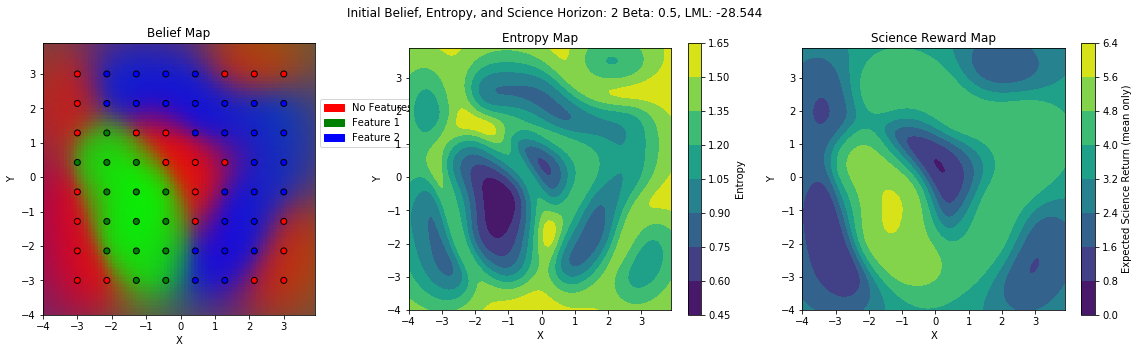

Final Kernel
Kernel values for each feature
4.02**2 * RBF(length_scale=0.936)
3.16**2 * RBF(length_scale=1.3)
32**2 * RBF(length_scale=1.6)


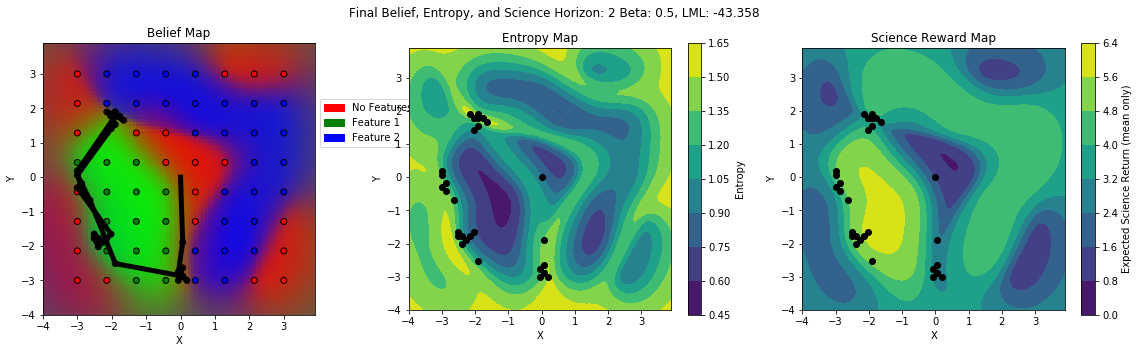

In [40]:
# BETA = 0.5
beta = 0.5

parameterStr = "Horizon: " + str(horizon) + " Beta: " + str(beta)
model = BeliefModel(kernel, optimize)
model.fit(X_init, y_init)
print("Initial Kernel")
model.print_kernel()
model.plot(title="Initial Belief, Entropy, and Science " + parameterStr, plot_types = ('belief','entropy', 'science'))
    
explorer = test_explorer(model,budget, horizon, beta)

print("Final Kernel")
explorer.model.print_kernel()

explorer.model.plot(title="Final Belief, Entropy, and Science "+ parameterStr,plot_types = ('belief','entropy', 'science'),lines=np.array(explorer.points_traveled),points=np.array(explorer.points_traveled))


Initial Kernel
Kernel values for each feature
4.36**2 * RBF(length_scale=0.959)
23.6**2 * RBF(length_scale=2.32)
4.79**2 * RBF(length_scale=1.5)


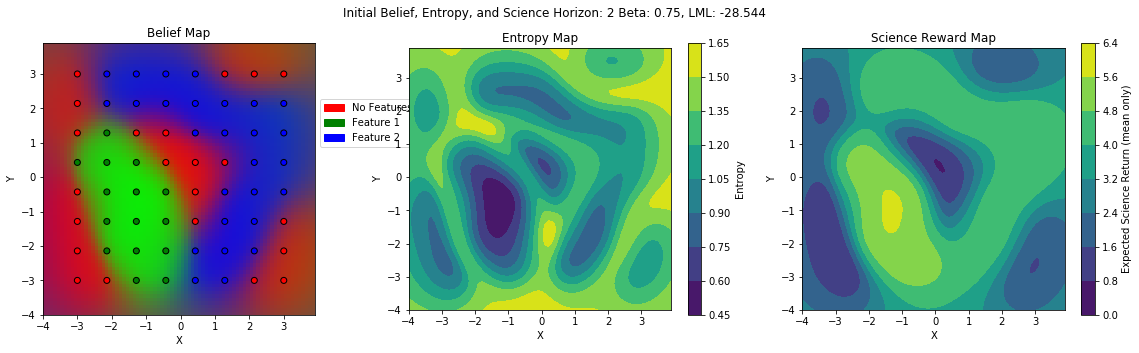

Final Kernel
Kernel values for each feature
1.04**2 * RBF(length_scale=0.909)
32**2 * RBF(length_scale=2.26)
62.7**2 * RBF(length_scale=1.5)


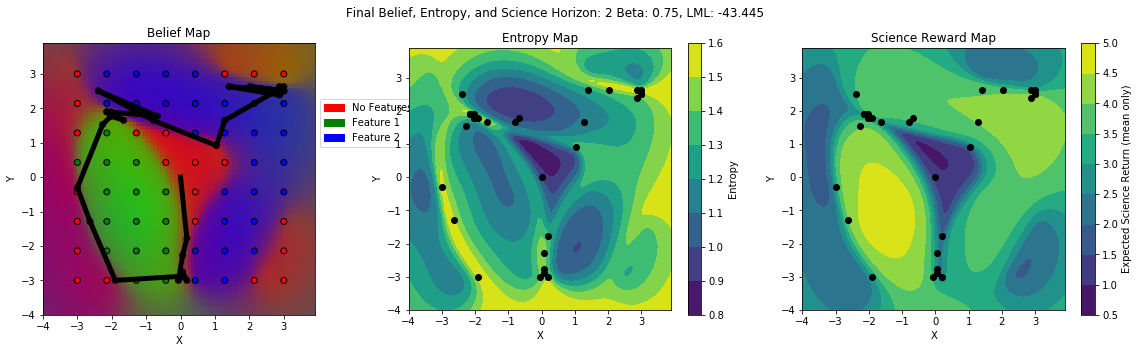

In [41]:
# BETA = 0.75
beta = 0.75


parameterStr = "Horizon: " + str(horizon) + " Beta: " + str(beta)
model = BeliefModel(kernel, optimize)
model.fit(X_init, y_init)
print("Initial Kernel")
model.print_kernel()
model.plot(title="Initial Belief, Entropy, and Science " + parameterStr, plot_types = ('belief','entropy', 'science'))
    
explorer = test_explorer(model,budget, horizon, beta)

print("Final Kernel")
explorer.model.print_kernel()

explorer.model.plot(title="Final Belief, Entropy, and Science "+ parameterStr,plot_types = ('belief','entropy', 'science'),lines=np.array(explorer.points_traveled),points=np.array(explorer.points_traveled))


### Beta Question (2.5 points): 
**Describe the effect on the myopic robot as beta varies.  Is the behavior what you expected?**


---------------------------------------------------

*"""YOUR ANSWER HERE"""*

###*BEGIN SOLUTION*###

With Beta = 0, we have a pure exploiter that will just use it's current belief map to find the highest expected science value and repeated sample there.  While at Beta = 1, we have a pure explorer that will choose the next location based off the highest map entropy in it's look horizon.  In between 0 and 1, the robot starts to increase it's exploration of the high entropy points, while still trying to stay near potentially high science areas (the green feature).  The behavior is mostly as expected, given the look horizon, in that the robot always stays around the green feature (since it is the highest science value), but as beta increases it spends more and more time near the edges of the green feature so it can lower the local entropy in those regions.

Side note: Hopefully they remark on the connection between belief map changes and beta, and how that drives further behavior (since it is updating its belief model after every step, the greedy approach can have large impacts on the path taken that can make it seem counter-intuitive, especially given a fixed look horizon).

###*END SOLUTION*###

---------------------------------------------------

## Look Horizon Variation: 0.5, 2, 4

For the next three examples, we will vary vary the look horizon while holding beta constant at 0.8

In [42]:
beta = 0.8

Initial Kernel
Kernel values for each feature
4.36**2 * RBF(length_scale=0.959)
23.6**2 * RBF(length_scale=2.32)
4.79**2 * RBF(length_scale=1.5)


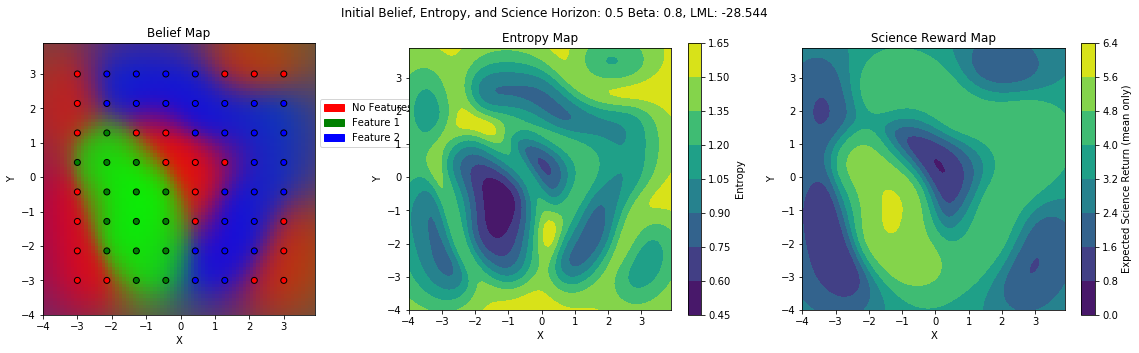

Final Kernel
Kernel values for each feature
1.19**2 * RBF(length_scale=0.00156)
316**2 * RBF(length_scale=2.74)
19.1**2 * RBF(length_scale=1.61)


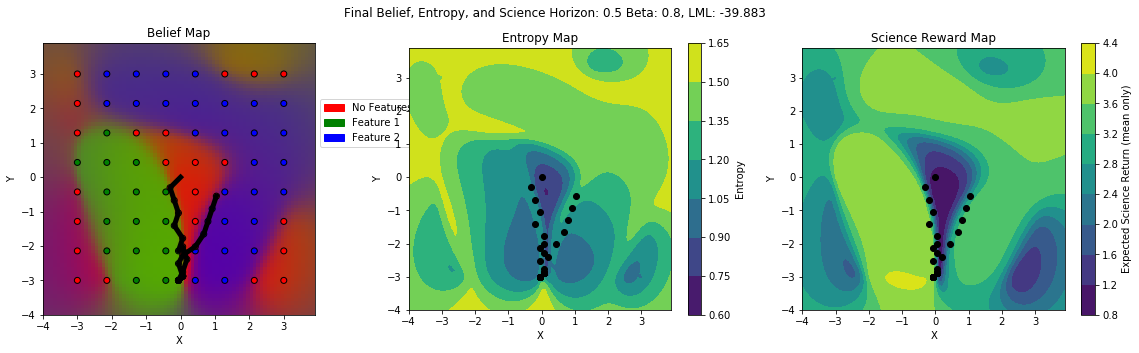

In [43]:
# Look Horizon = 0.5
horizon = 0.5

parameterStr = "Horizon: " + str(horizon) + " Beta: " + str(beta)
model = BeliefModel(kernel, optimize)
model.fit(X_init, y_init)
print("Initial Kernel")
model.print_kernel()
model.plot(title="Initial Belief, Entropy, and Science " + parameterStr, plot_types = ('belief','entropy', 'science'))
    
explorer = test_explorer(model,budget, horizon, beta)

print("Final Kernel")
explorer.model.print_kernel()

explorer.model.plot(title="Final Belief, Entropy, and Science "+ parameterStr,plot_types = ('belief','entropy', 'science'),lines=np.array(explorer.points_traveled),points=np.array(explorer.points_traveled))


Initial Kernel
Kernel values for each feature
4.36**2 * RBF(length_scale=0.959)
23.6**2 * RBF(length_scale=2.32)
4.79**2 * RBF(length_scale=1.5)


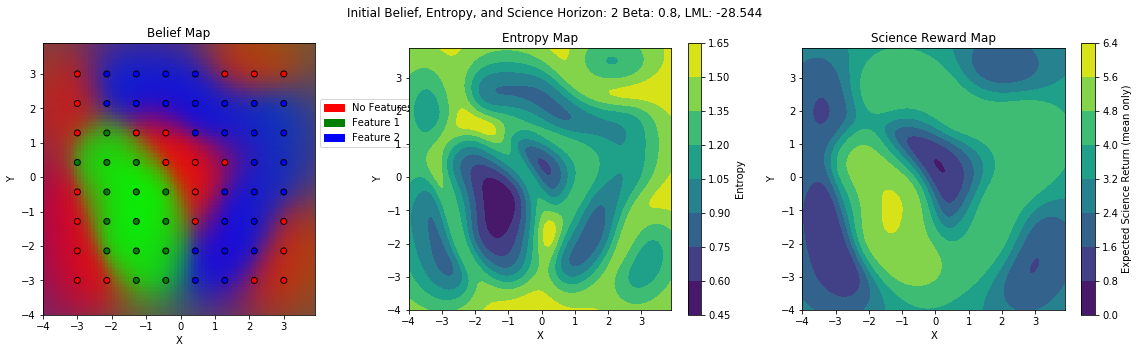

Final Kernel
Kernel values for each feature
1.04**2 * RBF(length_scale=0.84)
136**2 * RBF(length_scale=1.86)
6.42**2 * RBF(length_scale=1.55)


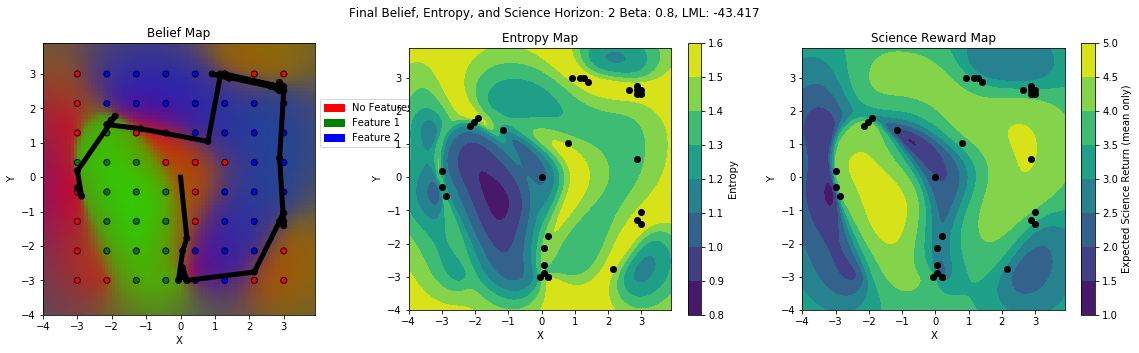

In [44]:
# Look Horizon = 2
horizon = 2

parameterStr = "Horizon: " + str(horizon) + " Beta: " + str(beta)
model = BeliefModel(kernel, optimize)
model.fit(X_init, y_init)
print("Initial Kernel")
model.print_kernel()
model.plot(title="Initial Belief, Entropy, and Science " + parameterStr, plot_types = ('belief','entropy', 'science'))
    
explorer = test_explorer(model,budget, horizon, beta)

print("Final Kernel")
explorer.model.print_kernel()

explorer.model.plot(title="Final Belief, Entropy, and Science "+ parameterStr,plot_types = ('belief','entropy', 'science'),lines=np.array(explorer.points_traveled),points=np.array(explorer.points_traveled))


Initial Kernel
Kernel values for each feature
4.36**2 * RBF(length_scale=0.959)
23.6**2 * RBF(length_scale=2.32)
4.79**2 * RBF(length_scale=1.5)


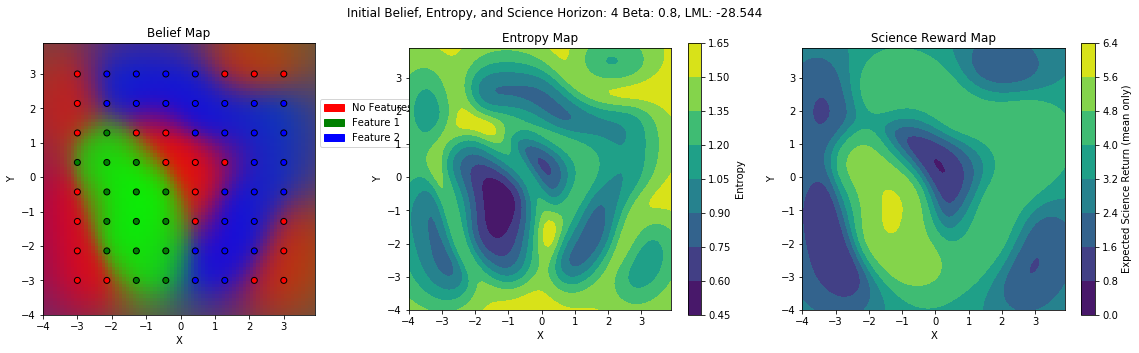

Final Kernel
Kernel values for each feature
4.07**2 * RBF(length_scale=0.91)
316**2 * RBF(length_scale=1.7)
1.94**2 * RBF(length_scale=1.29)


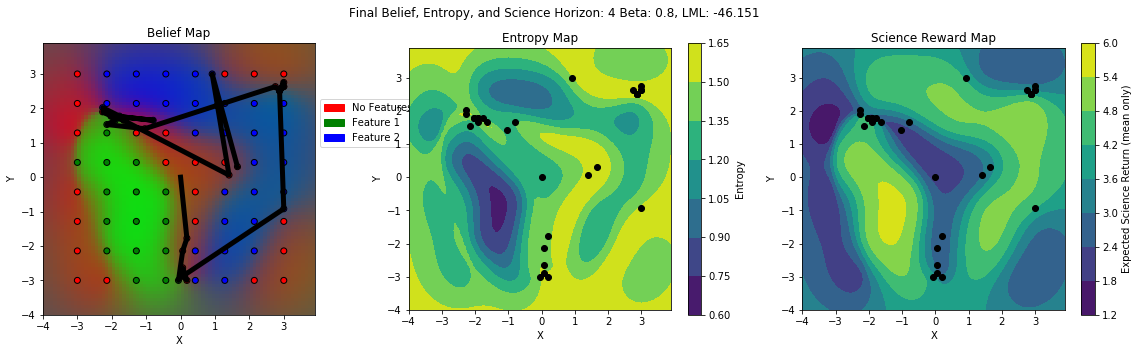

In [45]:
# Look Horizon = 4
horizon = 4

parameterStr = "Horizon: " + str(horizon) + " Beta: " + str(beta)
model = BeliefModel(kernel, optimize)
model.fit(X_init, y_init)
print("Initial Kernel")
model.print_kernel()
model.plot(title="Initial Belief, Entropy, and Science " + parameterStr, plot_types = ('belief','entropy', 'science'))
    
explorer = test_explorer(model,budget, horizon, beta)

print("Final Kernel")
explorer.model.print_kernel()

explorer.model.plot(title="Final Belief, Entropy, and Science "+ parameterStr,plot_types = ('belief','entropy', 'science'),lines=np.array(explorer.points_traveled),points=np.array(explorer.points_traveled))


### Look Horizon Question (2.5 points): 
**As the look horizon increased, did the behavior line up with your expectations?  What did you notice about the initial vs. final belief map differences from different look horizons?**

---------------------------------------------------

*"""YOUR ANSWER HERE"""*

###*BEGIN SOLUTION*###

Overall, yes the behavior as the look horizon increases seems intuitive in that more of the map is explored for a larger look horizon.  The look horizon can have a large impact on the final belief map.  For example, look at the look horizon = 0.5 final belief map.  Since the look horizon is so short, many of the points are bunched up tightly together.  This causes the optimized kernel to be much different than the original one and leads to much larger uncertainty (higher entropy) nearly everywhere else on the belief map, except near the corridor that the explorer took.


###*END SOLUTION*###

---------------------------------------------------

# Belief Map Variation:
The last six examples will compare different belief map behavior with an "exploiter" (beta = 0.25) vs. "explorer (beta = 0.75).  We will utilize an Anisotropic Kernel GP, Matern Kernel GP, and a KNeighbors classifier.

In [46]:
budget = {'distance': 50, 'sampling': 30}
horizon = 2
optimize = True

Initial Kernel
Kernel values for each feature
3.95**2 * RBF(length_scale=[0.903, 1.18])
21.1**2 * RBF(length_scale=[2.33, 3.43])
8.33**2 * RBF(length_scale=[1.69, 1.56])


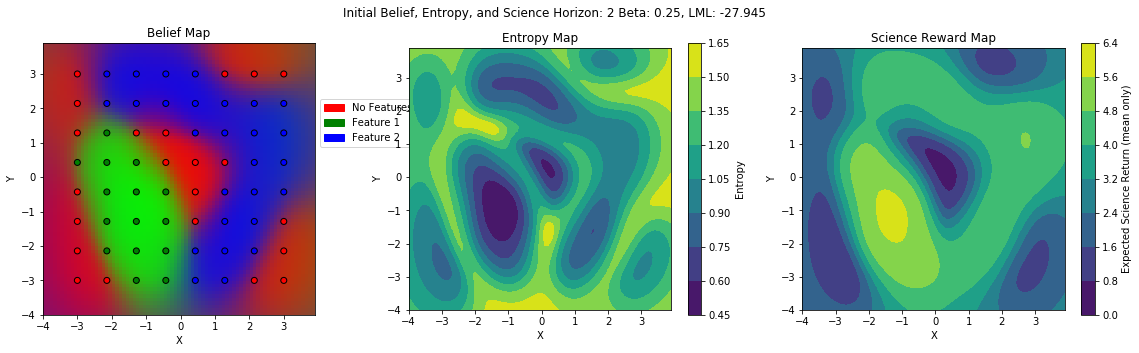

Final Kernel
Kernel values for each feature
1.93**2 * RBF(length_scale=[0.84, 1.33])
3.37**2 * RBF(length_scale=[0.914, 2.61])
4.03**2 * RBF(length_scale=[1.16, 1.71])


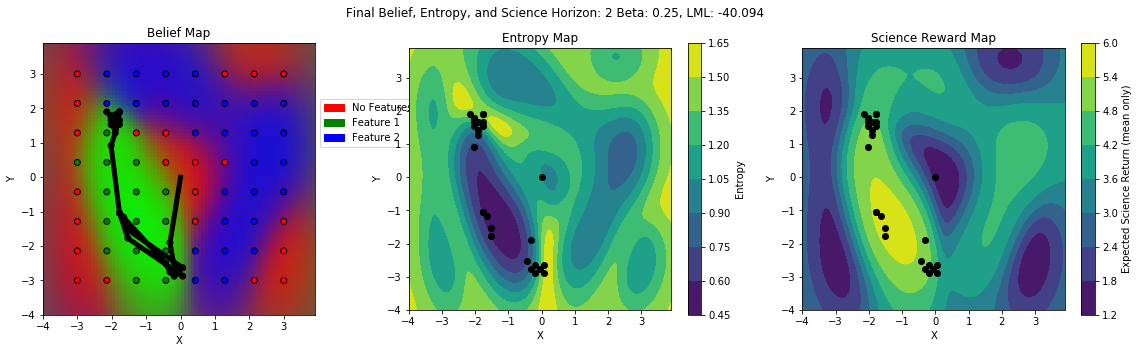

In [47]:
# Anisotropic - Beta = 0.25
beta= 0.25
kernel = 1.0 * RBF([1.0,1.0])

parameterStr = "Horizon: " + str(horizon) + " Beta: " + str(beta)
model = BeliefModel(kernel, optimize)
model.fit(X_init, y_init)
print("Initial Kernel")
model.print_kernel()
model.plot(title="Initial Belief, Entropy, and Science " + parameterStr, plot_types = ('belief','entropy', 'science'))
    
explorer = test_explorer(model,budget, horizon, beta)

print("Final Kernel")
explorer.model.print_kernel()

explorer.model.plot(title="Final Belief, Entropy, and Science "+ parameterStr,plot_types = ('belief','entropy', 'science'),lines=np.array(explorer.points_traveled),points=np.array(explorer.points_traveled))


Initial Kernel
Kernel values for each feature
3.95**2 * RBF(length_scale=[0.903, 1.18])
21.1**2 * RBF(length_scale=[2.33, 3.43])
8.33**2 * RBF(length_scale=[1.69, 1.56])


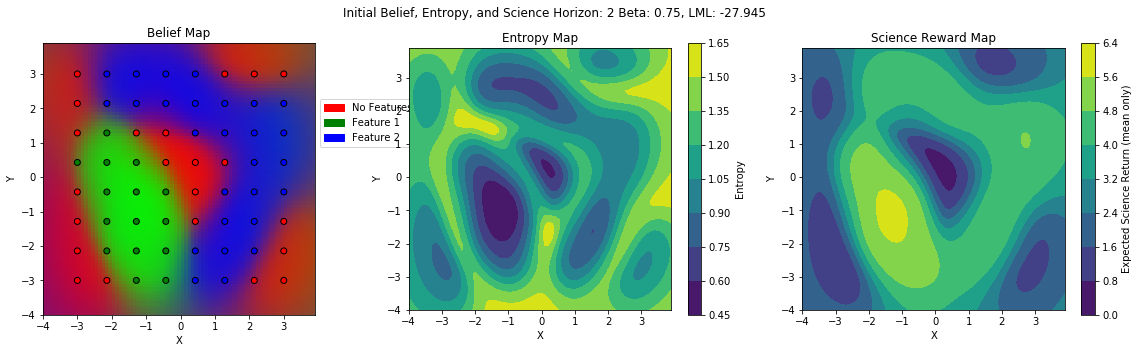

Final Kernel
Kernel values for each feature
2.97**2 * RBF(length_scale=[0.847, 1.26])
250**2 * RBF(length_scale=[1.6, 3.22])
22.6**2 * RBF(length_scale=[1.56, 1.31])


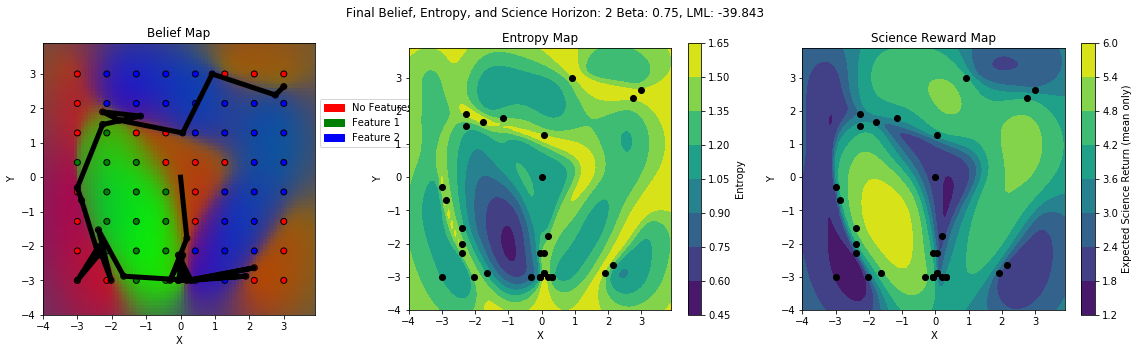

In [48]:
# Anisotropic - Beta = 0.75
beta= 0.75
kernel = 1.0 * RBF([1.0,1.0])

parameterStr = "Horizon: " + str(horizon) + " Beta: " + str(beta)
model = BeliefModel(kernel, optimize)
model.fit(X_init, y_init)
print("Initial Kernel")
model.print_kernel()
model.plot(title="Initial Belief, Entropy, and Science " + parameterStr, plot_types = ('belief','entropy', 'science'))
    
explorer = test_explorer(model,budget, horizon, beta)

print("Final Kernel")
explorer.model.print_kernel()

explorer.model.plot(title="Final Belief, Entropy, and Science "+ parameterStr,plot_types = ('belief','entropy', 'science'),lines=np.array(explorer.points_traveled),points=np.array(explorer.points_traveled))


Initial Kernel
Kernel values for each feature
3.71**2 * Matern(length_scale=1.19, nu=1.5)
3.3**2 * Matern(length_scale=2.38, nu=1.5)
4.35**2 * Matern(length_scale=1.58, nu=1.5)


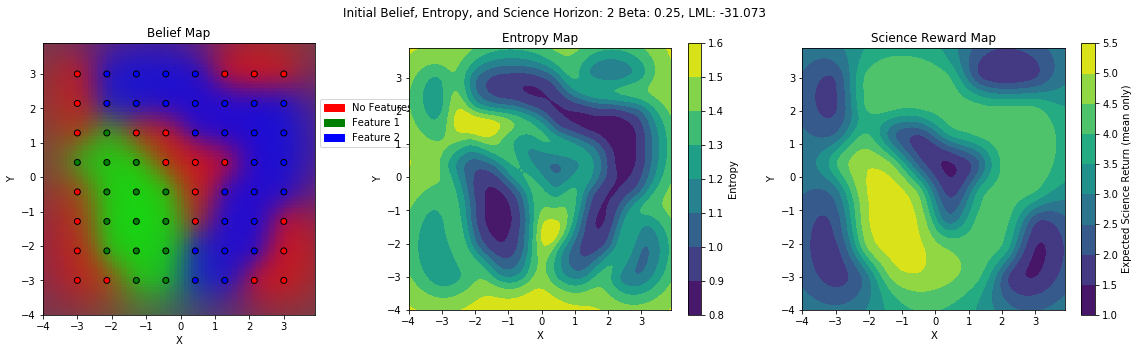

Final Kernel
Kernel values for each feature
3.27**2 * Matern(length_scale=1.13, nu=1.5)
4.64**2 * Matern(length_scale=1.82, nu=1.5)
3.75**2 * Matern(length_scale=1.75, nu=1.5)


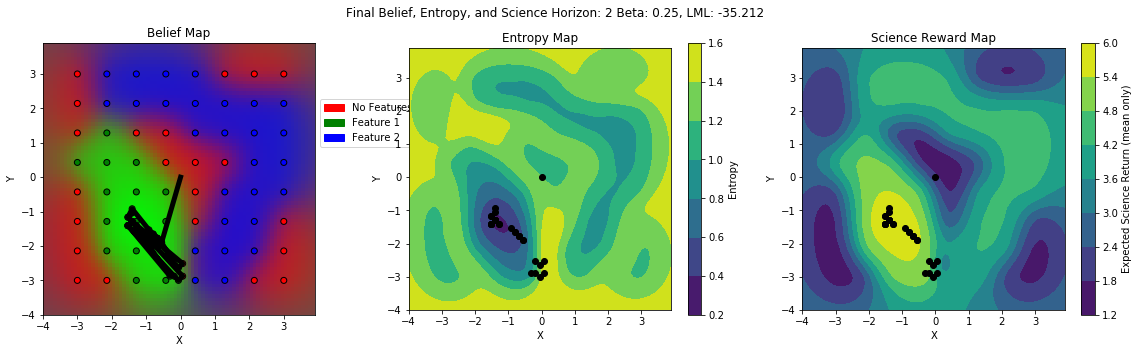

In [49]:
# Matern - Beta = 0.25
beta= 0.25
nu = 1.5
kernel = 1.0 * Matern(nu = nu)

parameterStr = "Horizon: " + str(horizon) + " Beta: " + str(beta)
model = BeliefModel(kernel, optimize)
model.fit(X_init, y_init)
print("Initial Kernel")
model.print_kernel()
model.plot(title="Initial Belief, Entropy, and Science " + parameterStr, plot_types = ('belief','entropy', 'science'))
    
explorer = test_explorer(model,budget, horizon, beta)

print("Final Kernel")
explorer.model.print_kernel()

explorer.model.plot(title="Final Belief, Entropy, and Science "+ parameterStr,plot_types = ('belief','entropy', 'science'),lines=np.array(explorer.points_traveled),points=np.array(explorer.points_traveled))


Initial Kernel
Kernel values for each feature
3.71**2 * Matern(length_scale=1.19, nu=1.5)
3.3**2 * Matern(length_scale=2.38, nu=1.5)
4.35**2 * Matern(length_scale=1.58, nu=1.5)


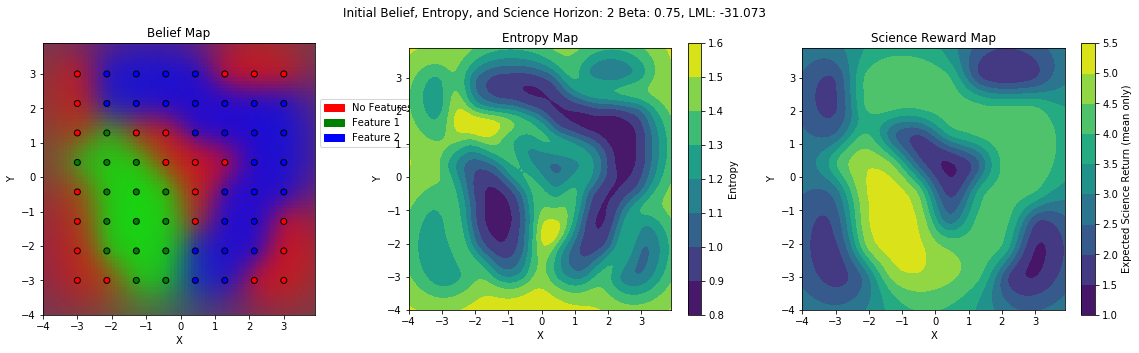

Final Kernel
Kernel values for each feature
1.62**2 * Matern(length_scale=1.02, nu=1.5)
6.66**2 * Matern(length_scale=2.09, nu=1.5)
8.31**2 * Matern(length_scale=2.13, nu=1.5)


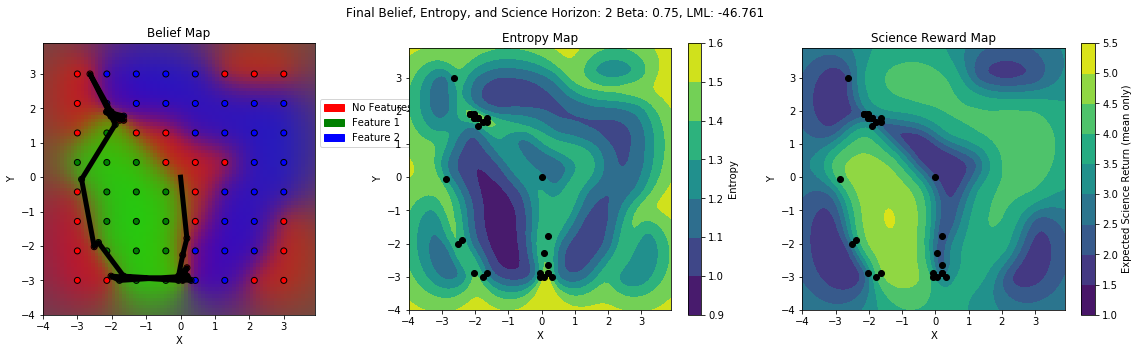

In [50]:
# Matern - Beta = 0.75
beta= 0.75
nu = 1.5
kernel = 1.0 * Matern(nu = nu)

parameterStr = "Horizon: " + str(horizon) + " Beta: " + str(beta)
model = BeliefModel(kernel, optimize)
model.fit(X_init, y_init)
print("Initial Kernel")
model.print_kernel()
model.plot(title="Initial Belief, Entropy, and Science " + parameterStr, plot_types = ('belief','entropy', 'science'))
    
explorer = test_explorer(model,budget, horizon, beta)

print("Final Kernel")
explorer.model.print_kernel()

explorer.model.plot(title="Final Belief, Entropy, and Science "+ parameterStr,plot_types = ('belief','entropy', 'science'),lines=np.array(explorer.points_traveled),points=np.array(explorer.points_traveled))


Initial Kernel
K-Neighbors Classifier
n_neighbors = 8


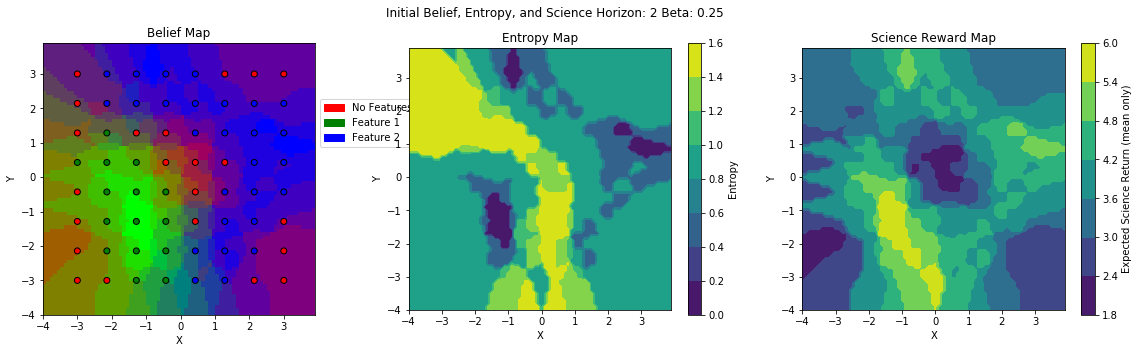

Final Kernel
K-Neighbors Classifier
n_neighbors = 8


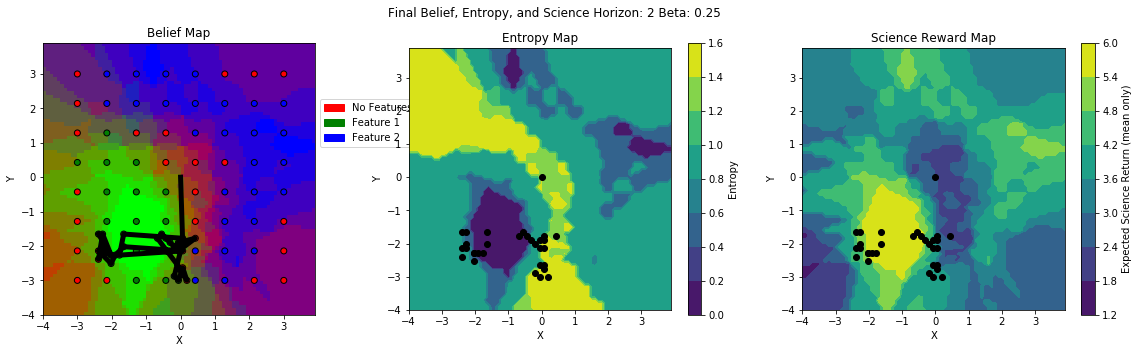

In [51]:
# Kneighbors - Beta = 0.25
beta= 0.25

parameterStr = "Horizon: " + str(horizon) + " Beta: " + str(beta)
model = BeliefModel(gpFlag = False)
model.fit(X_init, y_init)
print("Initial Kernel")
model.print_kernel()
model.plot(title="Initial Belief, Entropy, and Science " + parameterStr, plot_types = ('belief','entropy', 'science'))
    
explorer = test_explorer(model,budget, horizon, beta)

print("Final Kernel")
explorer.model.print_kernel()

explorer.model.plot(title="Final Belief, Entropy, and Science "+ parameterStr,plot_types = ('belief','entropy', 'science'),lines=np.array(explorer.points_traveled),points=np.array(explorer.points_traveled))


Initial Kernel
K-Neighbors Classifier
n_neighbors = 8


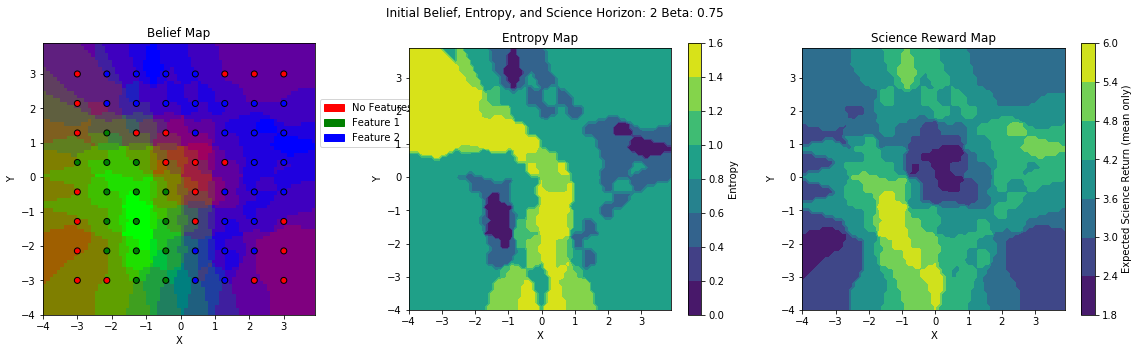

Final Kernel
K-Neighbors Classifier
n_neighbors = 8


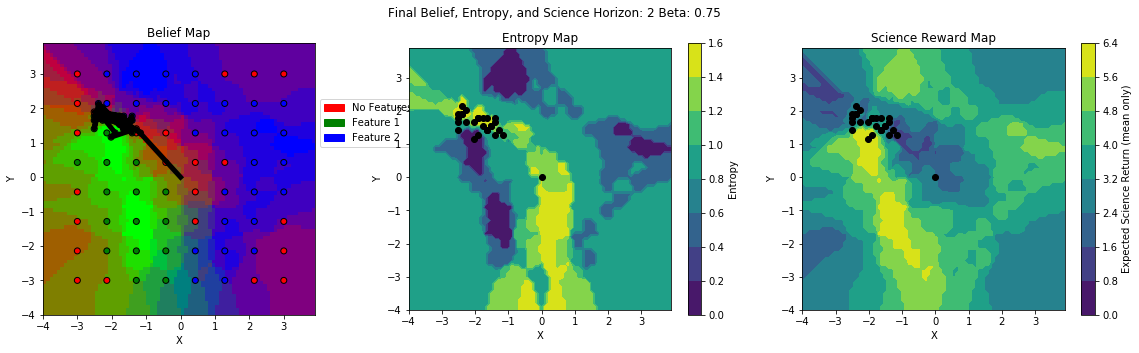

In [52]:
# Kneighbors - Beta = 0.75
beta= 0.75

parameterStr = "Horizon: " + str(horizon) + " Beta: " + str(beta)
model = BeliefModel(gpFlag = False)
model.fit(X_init, y_init)
print("Initial Kernel")
model.print_kernel()
model.plot(title="Initial Belief, Entropy, and Science " + parameterStr, plot_types = ('belief','entropy', 'science'))
    
explorer = test_explorer(model,budget, horizon, beta)

print("Final Kernel")
explorer.model.print_kernel()

explorer.model.plot(title="Final Belief, Entropy, and Science "+ parameterStr,plot_types = ('belief','entropy', 'science'),lines=np.array(explorer.points_traveled),points=np.array(explorer.points_traveled))


### Belief Model Question (5 points): 
**Describe briefly how the different belief models compare for the different beta values and fixed look horizon.  Is there one that you believe performs the best for this scenario?  Why?**

---------------------------------------------------

*"""YOUR ANSWER HERE"""*

###*BEGIN SOLUTION*###

( DOESN'T NEED TO BE EXACTLY THIS, BUT THEY SHOULD HAVE 1-2 SENTENCES ABOUT EACH BELIEF MODEL)

- Anisotropic Kernel GP:  This model performed similar to the isotropic Kernel GP, which is expected since there isn't a huge directional dependence on the features.  However, the motion of the robot through this belief state seemed more intuitive because it the anistropic kernel does seem to repersent the features slightly better in this case.
- Matern Kernel GP: This model was similar as well, but because it isn't as much of a smoothing function, there was less confidence about the green feature, except for in the very center.  This caused the "mostly expoiter" (beta = 0.25) to stay near the center and one corner, vs. exploring both corners as in the anisotropic GP case.
- KNeighbors Classifier: This model's behavior wasn't entirely counter-intuitive, but the final belief states are still not very understandable since they don't generalize well beyond local regions.  Also, since the the KNeighbors classifier has zero entropy when totally surrounded by points with the same feature, the "mostly expoiter" (beta = 0.25) stayed closer to the edges of the green feature after it sampled enough points to reduce the entropy down to zero internally on the feature.  This behavior is interesting because it does seem to do better at "bounding" the features when they are on the edge of the map.

(This last part is an opinion, but as long as they justify then they should get full points).

For this scenario, I think the anisotropic kernel GP is the best selection because it generalizes the feature shape accurately and the behavior is the most intuitive based on the beta values assigned.


###*END SOLUTION*###

---------------------------------------------------


# Build Your Own!

In the next two cells we ask you to build your own adaptive sampler using different budget, horizon, beta, and belief models.  Just follow the setup shown in the previous examples.  Look for some interesting behavior and/or strange belief map distortions using reasonable parameters (for example: try look horizon = 2, beta = 0.5 for an anisotropic RBF). Please answer the question after each cell.

In [56]:
## YOUR CODE HERE:


'''
budget = 
horizon = 
beta = 
model = '''


parameterStr = "Horizon: " + str(horizon) + " Beta: " + str(beta)
model.fit(X_init, y_init)
print("Initial Kernel")
model.print_kernel()
model.plot(title="Initial Belief, Entropy, and Science " + parameterStr, plot_types = ('belief','entropy', 'science'))
    
explorer = test_explorer(model,budget, horizon, beta)

print("Final Kernel")
explorer.model.print_kernel()

explorer.model.plot(title="Final Belief, Entropy, and Science "+ parameterStr,plot_types = ('belief','entropy', 'science'),lines=np.array(explorer.points_traveled),points=np.array(explorer.points_traveled))


### Qualitative Question 1 (5 pts):
**Describe your first custom test run, focus on your expectations when selecting the parameters vs. the actual movement of the robot.  If these don't match up, why not? (ex: could be due to the inaccuracy of the belief model, the belief model update process, and/or the myopic view of the robot)**

---------------------------------------------------

*"""YOUR ANSWER HERE"""*

###*BEGIN SOLUTION*###

(THIS IS VERY OPEN ENDED, AS LONG AS THEIR SCENARIO MATCHES UP WITH THEIR DESCRIPTION, AND IF THEIR EXPECTATIONS DON'T MATCH THEN MENTION THE REASON THEY THINK IT DOESN'T MATCH UP)


###*END SOLUTION*###

---------------------------------------------------

In [ ]:
## YOUR CODE HERE:



'''
budget = 
horizon = 
beta = 
model = '''




parameterStr = "Horizon: " + str(horizon) + " Beta: " + str(beta)
model.fit(X_init, y_init)
print("Initial Kernel")
model.print_kernel()
model.plot(title="Initial Belief, Entropy, and Science " + parameterStr, plot_types = ('belief','entropy', 'science'))
    
explorer = test_explorer(model,budget, horizon, beta)

print("Final Kernel")
explorer.model.print_kernel()

explorer.model.plot(title="Final Belief, Entropy, and Science "+ parameterStr,plot_types = ('belief','entropy', 'science'),lines=np.array(explorer.points_traveled),points=np.array(explorer.points_traveled))


### Qualitative Question 2 (5 pts):
**Describe your second custom test run, but this time focus on how the different parameters you chose (budget, horizon, beta, and model) relate to each other and have a confounding influence on the overall behavior the robot**

---------------------------------------------------

*"""YOUR ANSWER HERE"""*

###*BEGIN SOLUTION*###

(THIS IS VERY OPEN ENDED, AS LONG AS THEIR SCENARIO MATCHES UP WITH THEIR DESCRIPTION AND MENTION HOW AT LEAST TWO OF THE PARAMETERS RELATE TO EACH OTHER THEN THEY SHOULD GET THE FULL POINTS)

Some example things to mention:
- Beta vs. horizon:  Even if we have a full explore reward function, it will not be effective if our look horizon is too small!
- Budget and Beta and Horizon:  The distance budget needs to be large enough to effectively support the more exploratory (higher beta) robots.

###*END SOLUTION*###

---------------------------------------------------

### Final Question (5 pts):
**The algorithm implemented here was myopic (only looking at the next step), please describe at least one way you think it could be changed to give it a non-myopic action planning capability.**

---------------------------------------------------

*"""YOUR ANSWER HERE"""*

###*BEGIN SOLUTION*###

Some potential options (not all inclusive):
- Hold belief state constant while planning out X steps (could be another parameter) and assume that after taking each step that you have perfect information for a given radius around that step.

- Hold belief state constant while planning out X steps (could be another parameter) and simulate the expected belief state update from the current belief state and then "simulate update belief" with that state.  This will be probablistic so it will need to be framed in a monte carlo fashion to determine the best set of actions to take.  This can be evaluated by the total accumulated reward at the end of the Xth step.



###*END SOLUTION*###

---------------------------------------------------